I will be in charged of analyzing the employment of each sector
first the data will be used from the us bureau of labor statistics 
the employment will be in thousands

front page -> data tool -> industry at a glance -> alphabetical order -> click on a industry -> in the first table next to Employment, all employees (seasonally adjusted) -> back data

we use the seasonally adjusted employee data instead of non-adjusted data, our project aims to analyze overarching employment trends across industries or within a specific sector, including the impact of economic shifts, technological advancements, and major events, the seasonally adjusted data for all employees will provide a comprehensive overview. The seasonal adjustment identifys underlying trends by filtering out the regular seasonal fluctuations, which is particularly useful for long-term analysis.

a website with a list of urls based on alphebetical orders(industries), and my task is to go into each industry url, find a link inside(employee data), go into that link, and extra numeric data(precise employee number for each industry for the past ten years in each sector), then go outside and format it into a table

sectors without datas are ignored, there is only one sector that doesnt have the data


find other complementary information on a different websites 
ex: group industries, pie chart, show that i could do more complex analysis if someone were to pay me just additional exploration 
ex: total income of industries grouped, maybe a bunch of different sectors, and then make a pie chart 



In [1]:
from lxml import html
from bs4 import BeautifulSoup
from io import StringIO
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
import re
import pandas as pd 
import matplotlib.ticker as ticker
import bokeh.io
import imageio
import folium 

In [2]:
#a page of urls to each industry in alphabetical order, get a list of the urls 
url = "https://www.bls.gov/iag/tgs/iag_index_alpha.htm"
headers = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36'
}

response = requests.get(url, headers = headers)
soup = BeautifulSoup(response.text, 'lxml')

iag_tgs_div = soup.find('div', class_='iag--tgs')
list_items = iag_tgs_div.find_all('li')

full_links = []
for li in list_items:
    link = li.find('a', href=True) #for every li, extract the href link inside, append it to a list
    if link:
        full_links.append('https://www.bls.gov/iag/tgs/' + link['href'])


In [3]:
#with the list of urls, go into each one and extract the link to the data, put those links in a list 
full_links_to_data = []
for link in full_links:
    
    Industry_response = requests.get(link, headers = headers)
    soup2 = BeautifulSoup(Industry_response.text, 'lxml')

    table = soup2.find(lambda tag: tag.name == 'table' and 'emp1' in tag.get('id', ''))
    try:
        links = table.find_all('a', href = True)
    except (ValueError, IndexError, AttributeError):
        print(f"error: {link}")
        continue 
        
    for i, a_tag in enumerate(links):
        if "Employment, all employees" in a_tag.text:
            link_to_data = links[i + 1].get('href')
            full_links_to_data.append(link_to_data)
            break
        else:
            print(f"none for {link}")

none for https://www.bls.gov/iag/tgs/iag11.htm
none for https://www.bls.gov/iag/tgs/iag11.htm
error: https://www.bls.gov/iag/tgs/iag112.htm
none for https://www.bls.gov/iag/tgs/iag312.htm
none for https://www.bls.gov/iag/tgs/iag312.htm
error: https://www.bls.gov/iag/tgs/iag111.htm
error: https://www.bls.gov/iag/tgs/iag114.htm
error: https://www.bls.gov/iag/tgs/iag113.htm
error: https://www.bls.gov/iag/tgs/iag525.htm
error: https://www.bls.gov/iag/tgs/iag516.htm
error: https://www.bls.gov/iag/tgs/iag316.htm
error: https://www.bls.gov/iag/tgs/iag454.htm
error: https://www.bls.gov/iag/tgs/iag491.htm
none for https://www.bls.gov/iag/tgs/iag814.htm
none for https://www.bls.gov/iag/tgs/iag814.htm
error: https://www.bls.gov/iag/tgs/iag115.htm


In [4]:
#column months, row industry

#if NAICS code is two digits, concatinate it in a different table, two digits are main groups that is the sum of smaller industries
#if NAICS code is '-', this means its a big group that contains the sum of all data of indusitries within its groups
#if it's Service-providing or Goods-Producing Industries then these are two main groups that contains all industries

industry_data = pd.DataFrame()
sub_groupped_industry = pd.DataFrame()
main_groupped_industry = pd.DataFrame()
two_major_industries = pd.DataFrame()

for link in full_links_to_data:
    
    data_page = requests.get(link, headers = headers)
    try: # https://www.bls.gov/iag/tgs/iag453.htm this one doesnt have a table for some reason
        tables = pd.read_html(StringIO(data_page.text))[1]
    except (ValueError, IndexError):
        print(f"error: {link}")
        continue 
    
    page = html.fromstring(data_page.content)
    industry_name = page.xpath("//tr[@class='catalog'][th[@class='catalog' and text()='Industry:']]/td[@class='catalog']/text()")
    NAICS_Code = page.xpath("//tr[@class='catalog'][th[@class='catalog' and text()='NAICS Code:']]/td[@class='catalog']/text()")
    
    if not industry_name:
        print(f"No industry name: {link}")
        continue

    tables['Year'] = tables['Year'].astype(str)
    tables.drop(tables[(tables.Year == 'P : preliminary')].index, inplace=True) #tables from each industry without the P : preliminary part
    #dropping 2024 because it doesnt have data except for january and feb
    tables.drop(tables[(tables.Year == '2024')].index, inplace=True)
    
    # a giant table with 3 columns, year month and value for each industry
    table_melted = pd.melt(tables, id_vars=['Year'], var_name='Month', value_name='Value')  
    table_melted['Industry'] = industry_name[0]

    month_to_num = {
    "Jan": "01", "Feb": "02", "Mar": "03", "Apr": "04", "May": "05", "Jun": "06",
    "Jul": "07", "Aug": "08", "Sep": "09", "Oct": "10", "Nov": "11", "Dec": "12"
    }
    table_melted['Month'] = table_melted['Month'].map(month_to_num)
    table_melted['Year-Month'] = table_melted['Year'] + '-' + table_melted['Month']

    table_melted_sorted = table_melted.sort_values('Year-Month')

    table_melted_sorted['Value'] = pd.to_numeric(table_melted_sorted['Value'], errors='coerce')
    #(new - old)/old
    table_melted_sorted['percentage change'] = table_melted_sorted['Value'].pct_change() * 100

    if industry_name[0] == 'Goods-producing' or industry_name[0] == 'Service-providing':
        two_major_industries = pd.concat([two_major_industries, table_melted_sorted[['Industry', 'Year-Month', 'Value', 'percentage change']]])
    elif NAICS_Code[0] == '-':
        main_groupped_industry = pd.concat([main_groupped_industry, table_melted_sorted[['Industry', 'Year-Month', 'Value', 'percentage change']]])
    elif len(NAICS_Code[0]) == 2:
        sub_groupped_industry = pd.concat([sub_groupped_industry, table_melted_sorted[['Industry', 'Year-Month', 'Value', 'percentage change']]])
    else:
        industry_data = pd.concat([industry_data, table_melted_sorted[['Industry', 'Year-Month', 'Value', 'percentage change']]])


error: https://data.bls.gov/timeseries/CES4245300001?amp%253bdata_tool=XGtable&output_view=data&include_graphs=true


In [5]:
print(industry_data)
industry_data.to_csv('industry_data.csv', index=False)

                       Industry Year-Month   Value  percentage change
0                 Accommodation    2014-01  1877.7                NaN
10                Accommodation    2014-02  1879.6           0.101188
20                Accommodation    2014-03  1885.8           0.329857
30                Accommodation    2014-04  1889.5           0.196203
40                Accommodation    2014-05  1895.4           0.312252
..                          ...        ...     ...                ...
79   Wood product manufacturing    2023-08   417.3           0.529993
89   Wood product manufacturing    2023-09   416.5          -0.191709
99   Wood product manufacturing    2023-10   415.9          -0.144058
109  Wood product manufacturing    2023-11   415.1          -0.192354
119  Wood product manufacturing    2023-12   414.3          -0.192725

[9000 rows x 4 columns]


In [6]:
print(sub_groupped_industry)
sub_groupped_industry.to_csv('sub_groupped_industry.csv', index=False)

                            Industry Year-Month    Value  percentage change
0    Accommodation and food services    2014-01  12409.7                NaN
10   Accommodation and food services    2014-02  12423.3           0.109592
20   Accommodation and food services    2014-03  12486.3           0.507112
30   Accommodation and food services    2014-04  12527.7           0.331563
40   Accommodation and food services    2014-05  12566.7           0.311310
..                               ...        ...      ...                ...
79                   Wholesale trade    2023-08   6121.6           0.024509
89                   Wholesale trade    2023-09   6133.3           0.191127
99                   Wholesale trade    2023-10   6145.2           0.194023
109                  Wholesale trade    2023-11   6152.1           0.112283
119                  Wholesale trade    2023-12   6159.5           0.120284

[1800 rows x 4 columns]


In [7]:
#should be 9, 9*120 = 1080
print(main_groupped_industry)
main_groupped_industry.to_csv('main_groupped_industry.csv', index=False)

                                  Industry Year-Month    Value  \
0    Private education and health services    2014-01  21228.0   
10   Private education and health services    2014-02  21251.0   
20   Private education and health services    2014-03  21294.0   
30   Private education and health services    2014-04  21321.0   
40   Private education and health services    2014-05  21364.0   
..                                     ...        ...      ...   
79          Transportation and warehousing    2023-08   6548.7   
89          Transportation and warehousing    2023-09   6557.9   
99          Transportation and warehousing    2023-10   6549.4   
109         Transportation and warehousing    2023-11   6538.9   
119         Transportation and warehousing    2023-12   6520.6   

     percentage change  
0                  NaN  
10            0.108347  
20            0.202343  
30            0.126796  
40            0.201679  
..                 ...  
79           -0.418175  
89     

In [8]:
print(two_major_industries)
two_major_industries.to_csv('two_major_industries.csv', index=False)

              Industry Year-Month   Value  percentage change
0      Goods-producing    2014-01   18937                NaN
10     Goods-producing    2014-02   18988           0.269314
20     Goods-producing    2014-03   19037           0.258058
30     Goods-producing    2014-04   19103           0.346693
40     Goods-producing    2014-05   19141           0.198922
..                 ...        ...     ...                ...
79   Service-providing    2023-08  134784           0.131494
89   Service-providing    2023-09  135003           0.162482
99   Service-providing    2023-10  135178           0.129627
109  Service-providing    2023-11  135324           0.108006
119  Service-providing    2023-12  135581           0.189915

[240 rows x 4 columns]


In [9]:
#set industry as rows, column as years
pivot_data = industry_data.pivot(index='Industry', columns='Year-Month', values='Value')
pivot_data.to_csv('Pivot.csv')

data acquired, now visualization

line plot, bar plot, animated visuals, and heat map
animated - maybe x is industries grouped, y is number of employees, and have one for each month, see it moving over each month in 10 yrs

/tmp/ipykernel_40683/333334847.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


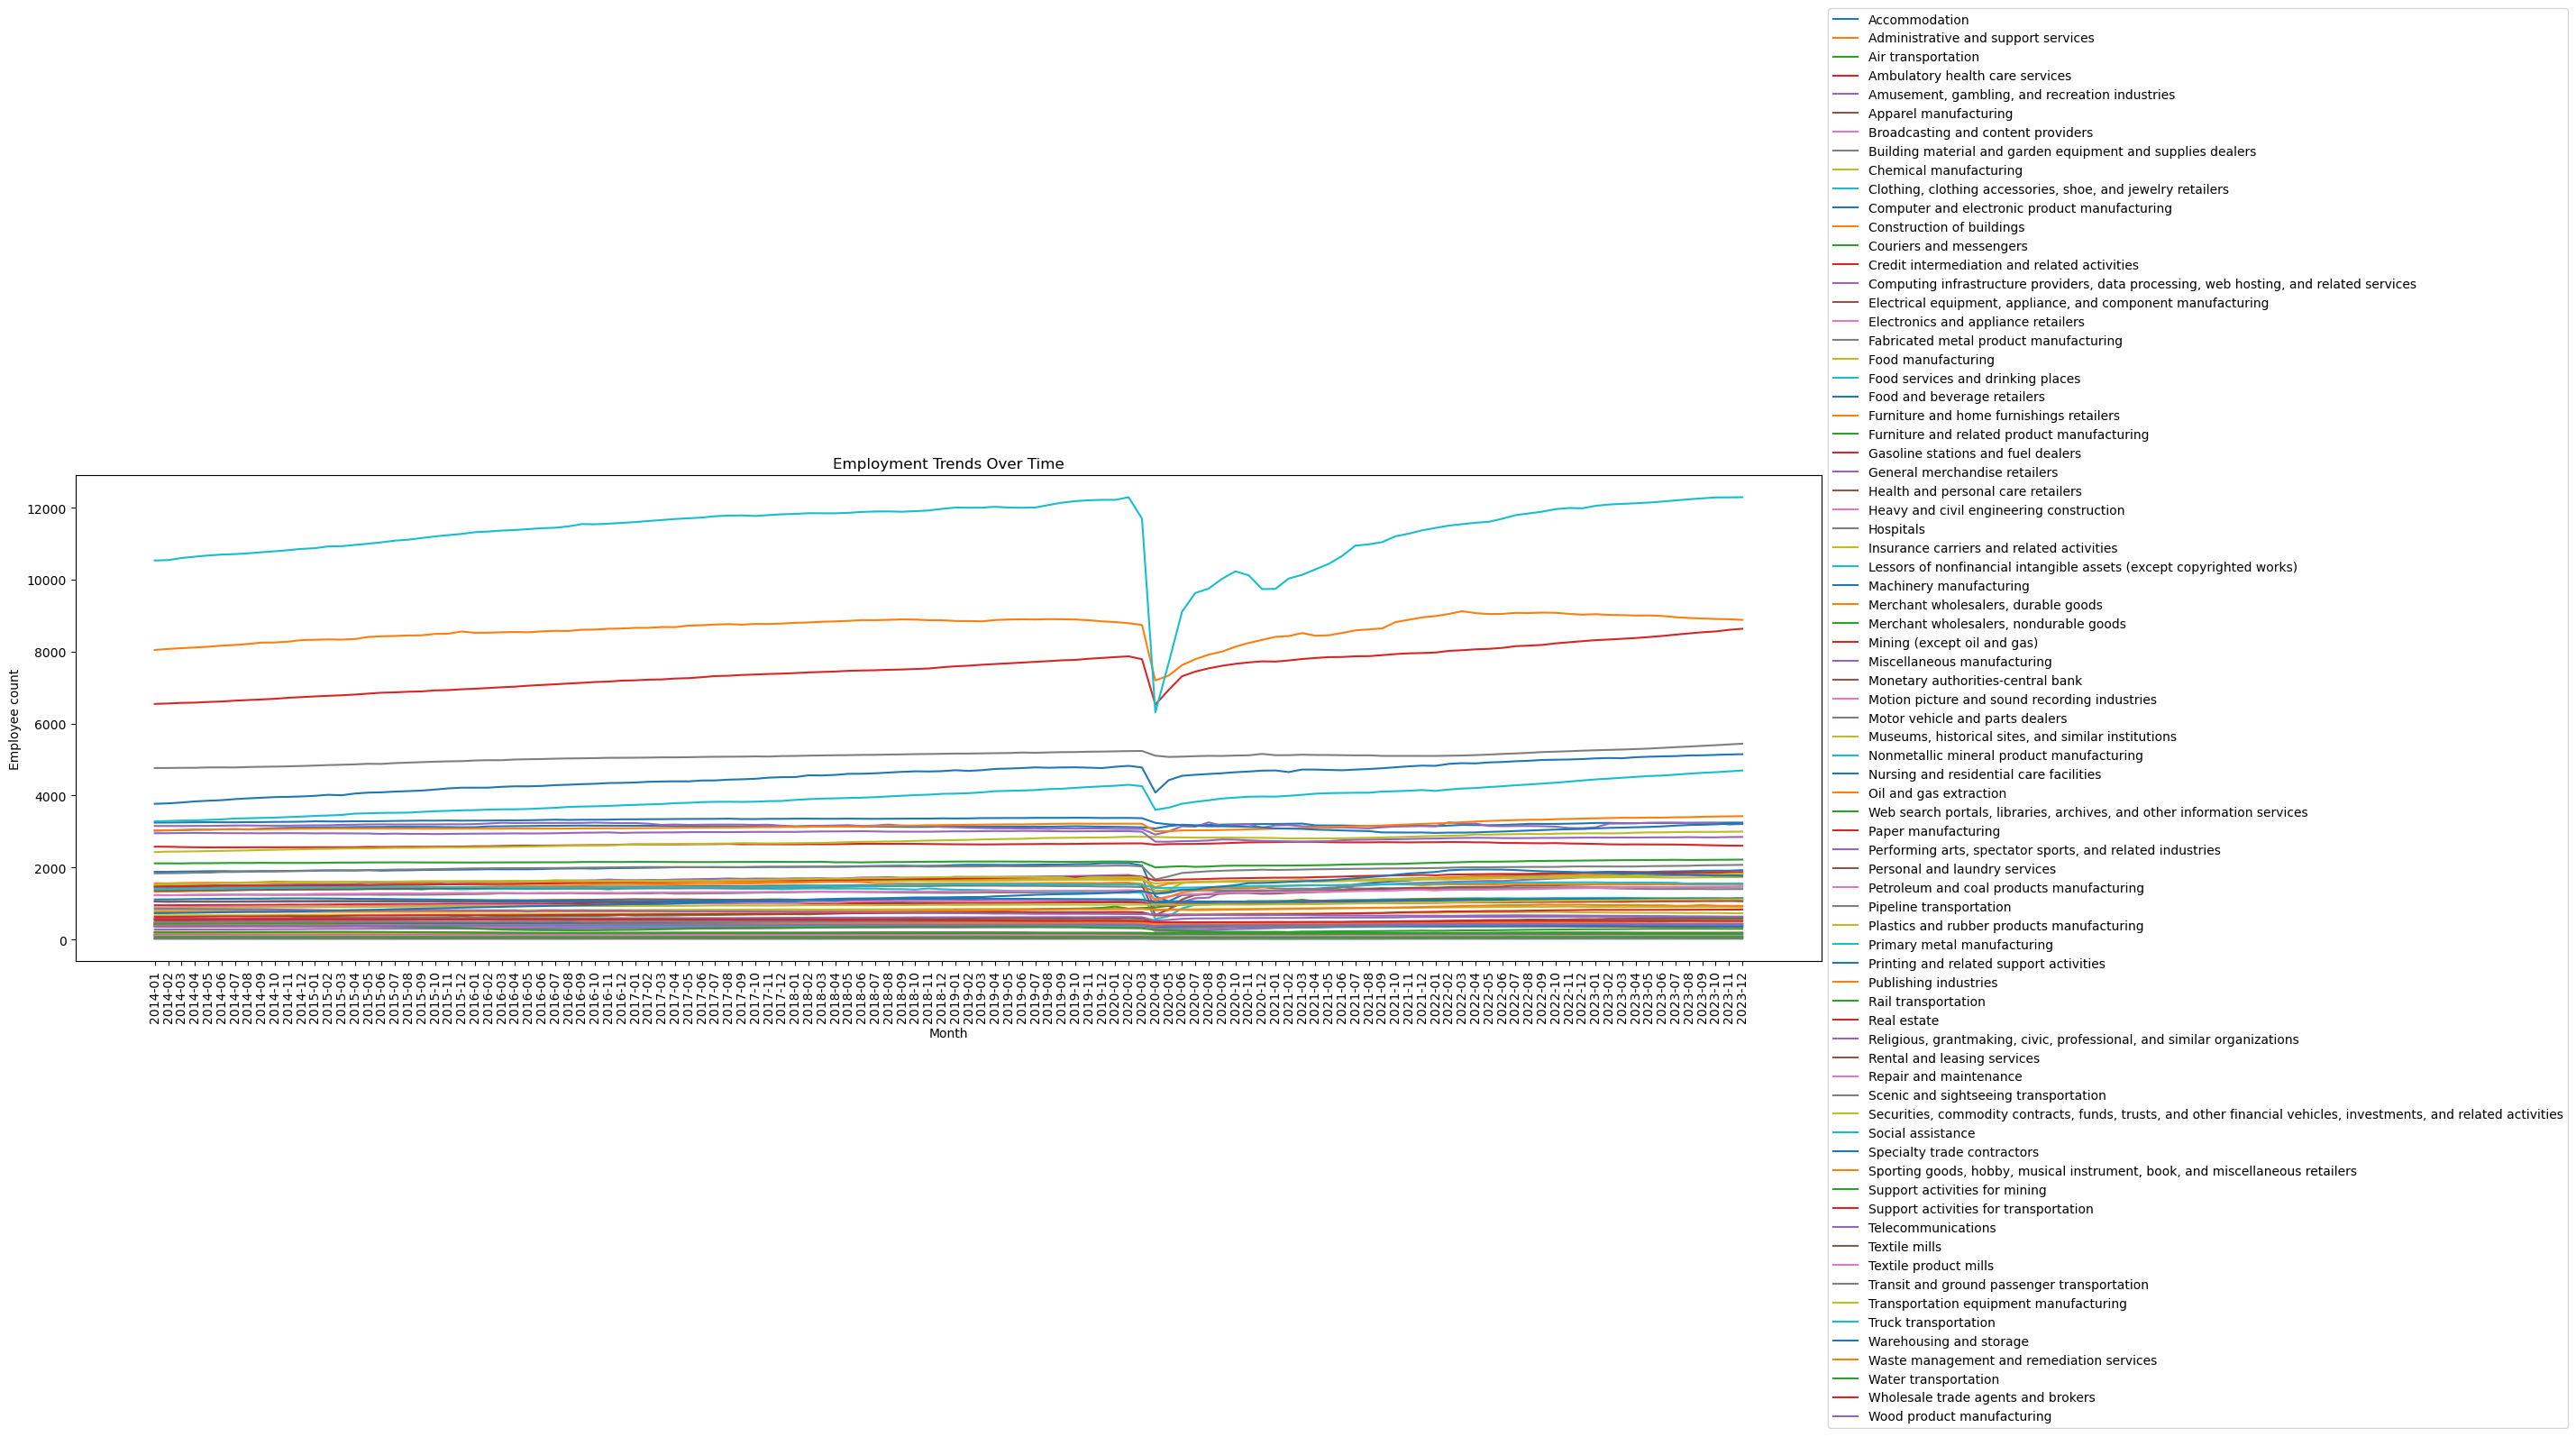

In [25]:
#line plot monthly
plt.figure(figsize=(25, 7))
for industry in industry_data['Industry'].unique():
    industry_subset = industry_data[industry_data['Industry'] == industry]
    plt.plot(industry_subset['Year-Month'], industry_subset['Value'], marker='', label=industry)
plt.xticks(rotation=90)
plt.title('Employment Trends Over Time')
plt.xlabel('Month')
plt.ylabel('Employee count')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig('/Users/shengmai/Desktop/winter2023-2024/141B/project/industry_line_graph_monthly.png', bbox_inches='tight', dpi = 300)

plt.show()


In [11]:
industry_data['Year'] = pd.to_datetime(industry_data['Year-Month']).dt.year
yearly_data = industry_data.groupby(['Industry', 'Year'])['Value'].mean().reset_index()
print(yearly_data)

                       Industry  Year        Value
0                 Accommodation  2014  1894.025000
1                 Accommodation  2015  1923.475000
2                 Accommodation  2016  1961.025000
3                 Accommodation  2017  2003.608333
4                 Accommodation  2018  2035.108333
..                          ...   ...          ...
745  Wood product manufacturing  2019   408.916667
746  Wood product manufacturing  2020   396.033333
747  Wood product manufacturing  2021   409.875000
748  Wood product manufacturing  2022   427.283333
749  Wood product manufacturing  2023   417.858333

[750 rows x 3 columns]


/tmp/ipykernel_40683/2336458079.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


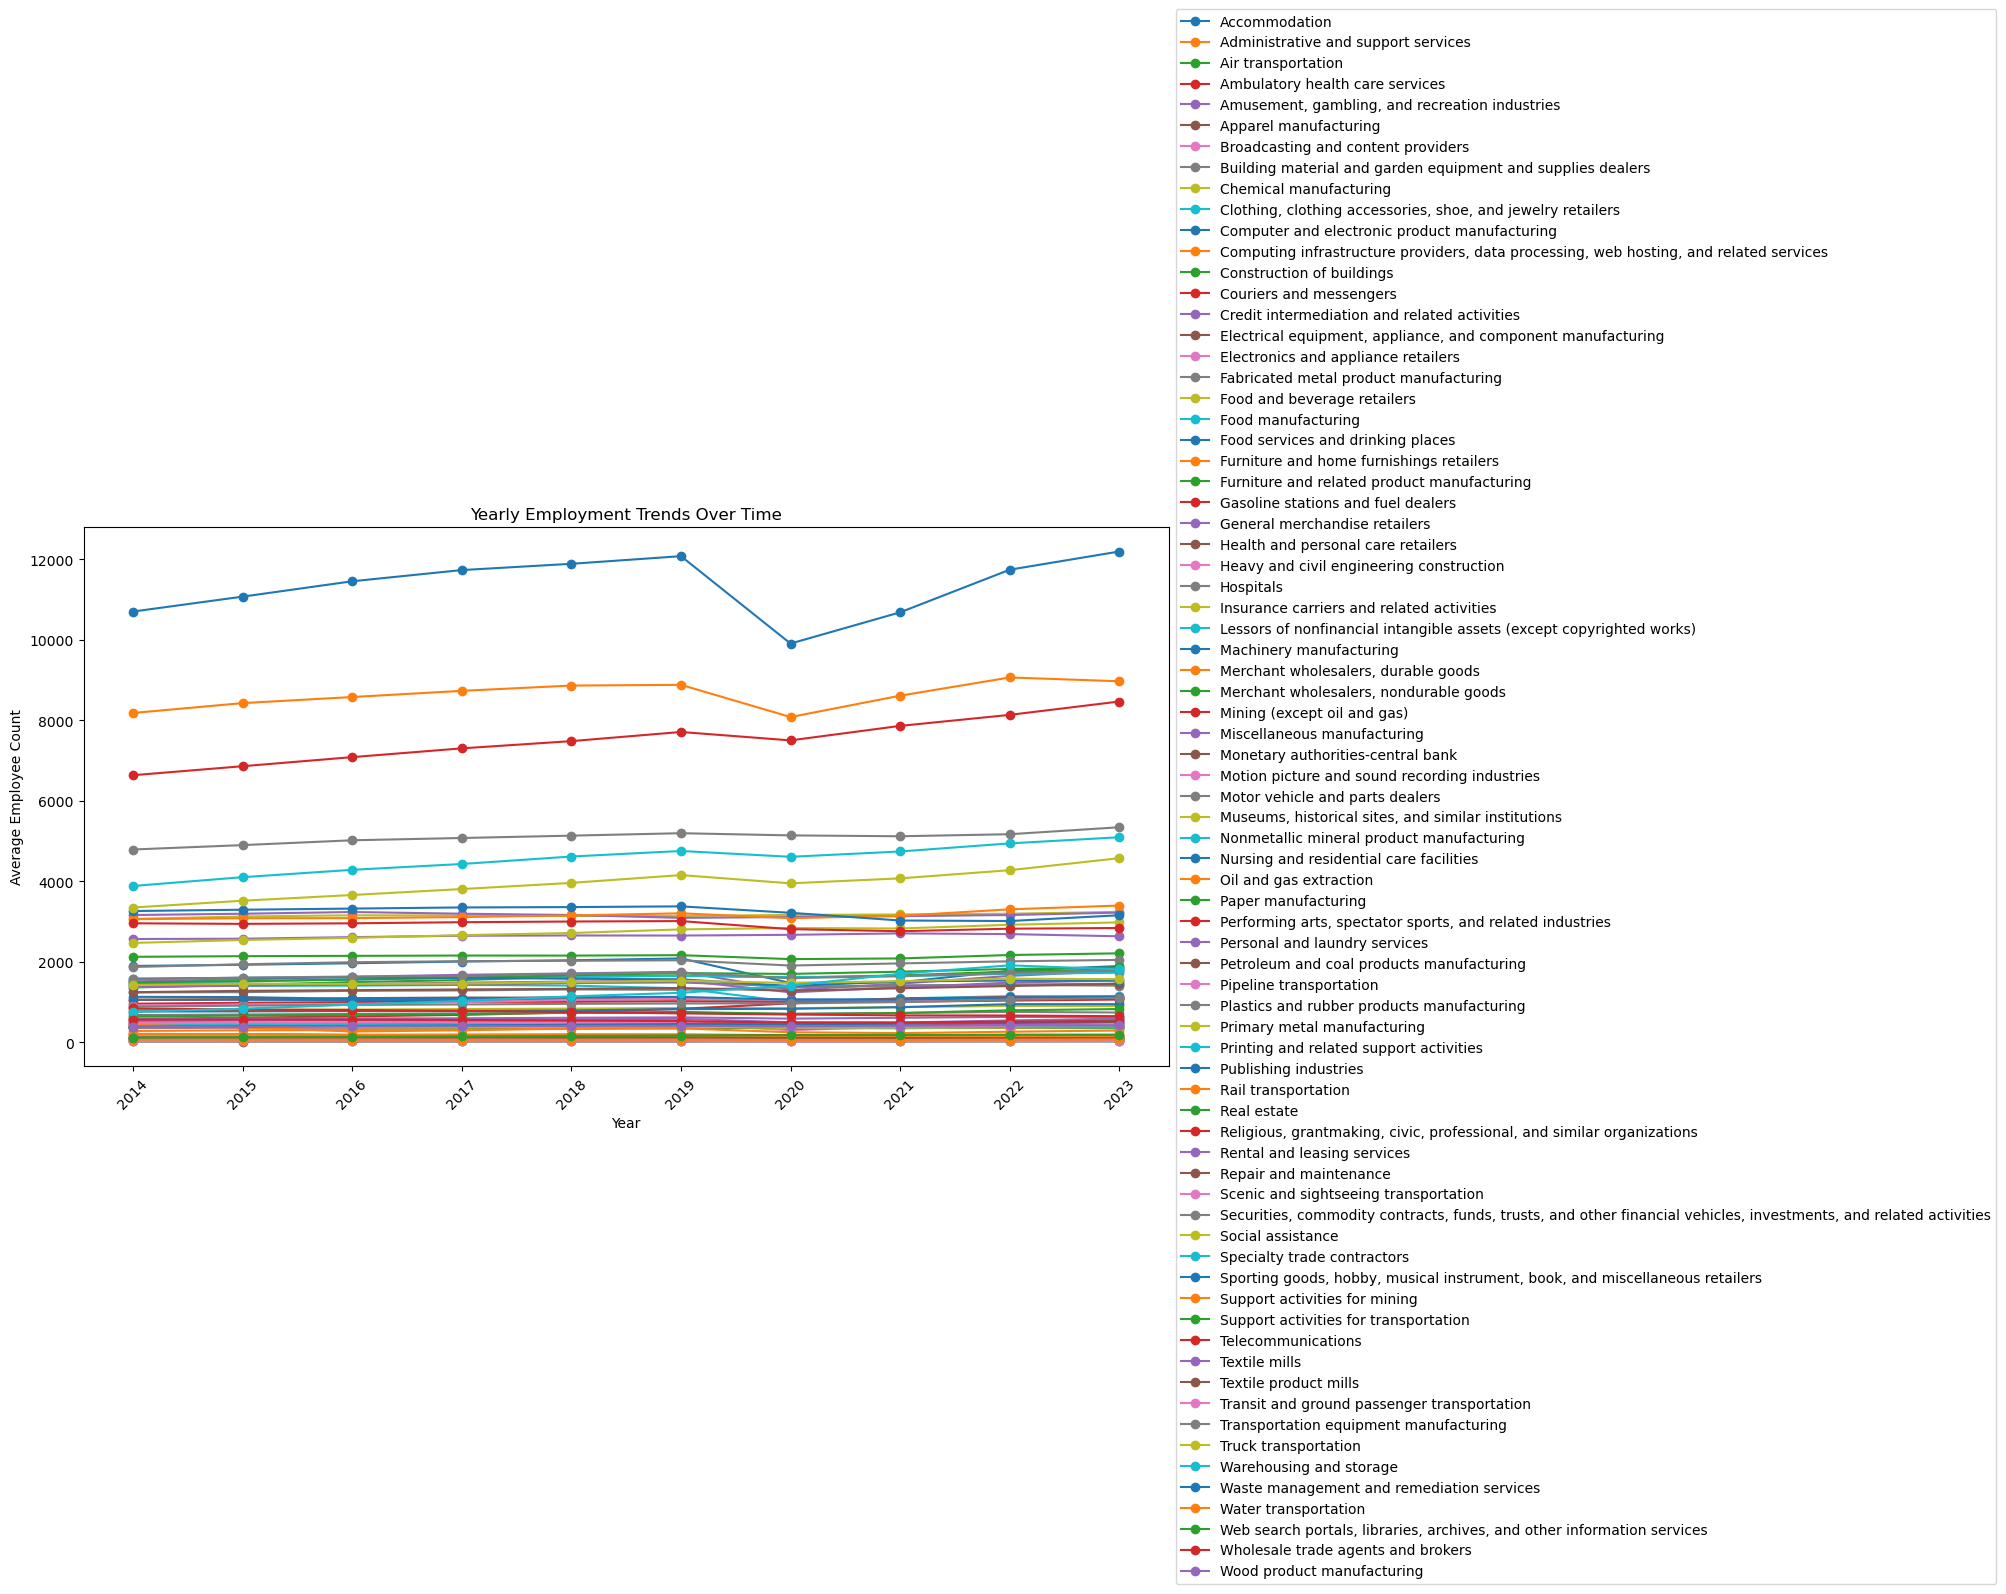

In [12]:
#line plot yearly

plt.figure(figsize=(14, 7))
for industry in yearly_data['Industry'].unique():
    industry_subset = yearly_data[yearly_data['Industry'] == industry]
    plt.plot(industry_subset['Year'], industry_subset['Value'], marker='o', label=industry)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.xticks(rotation=45)
plt.title('Yearly Employment Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Average Employee Count')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig('/Users/shengmai/Desktop/winter2023-2024/141B/project/industry_line_graph_yearly.png',bbox_inches='tight', dpi=300)

plt.show()

I want to group my data based on https://www.bls.gov/iag/tgs/iag_index_naics.htm

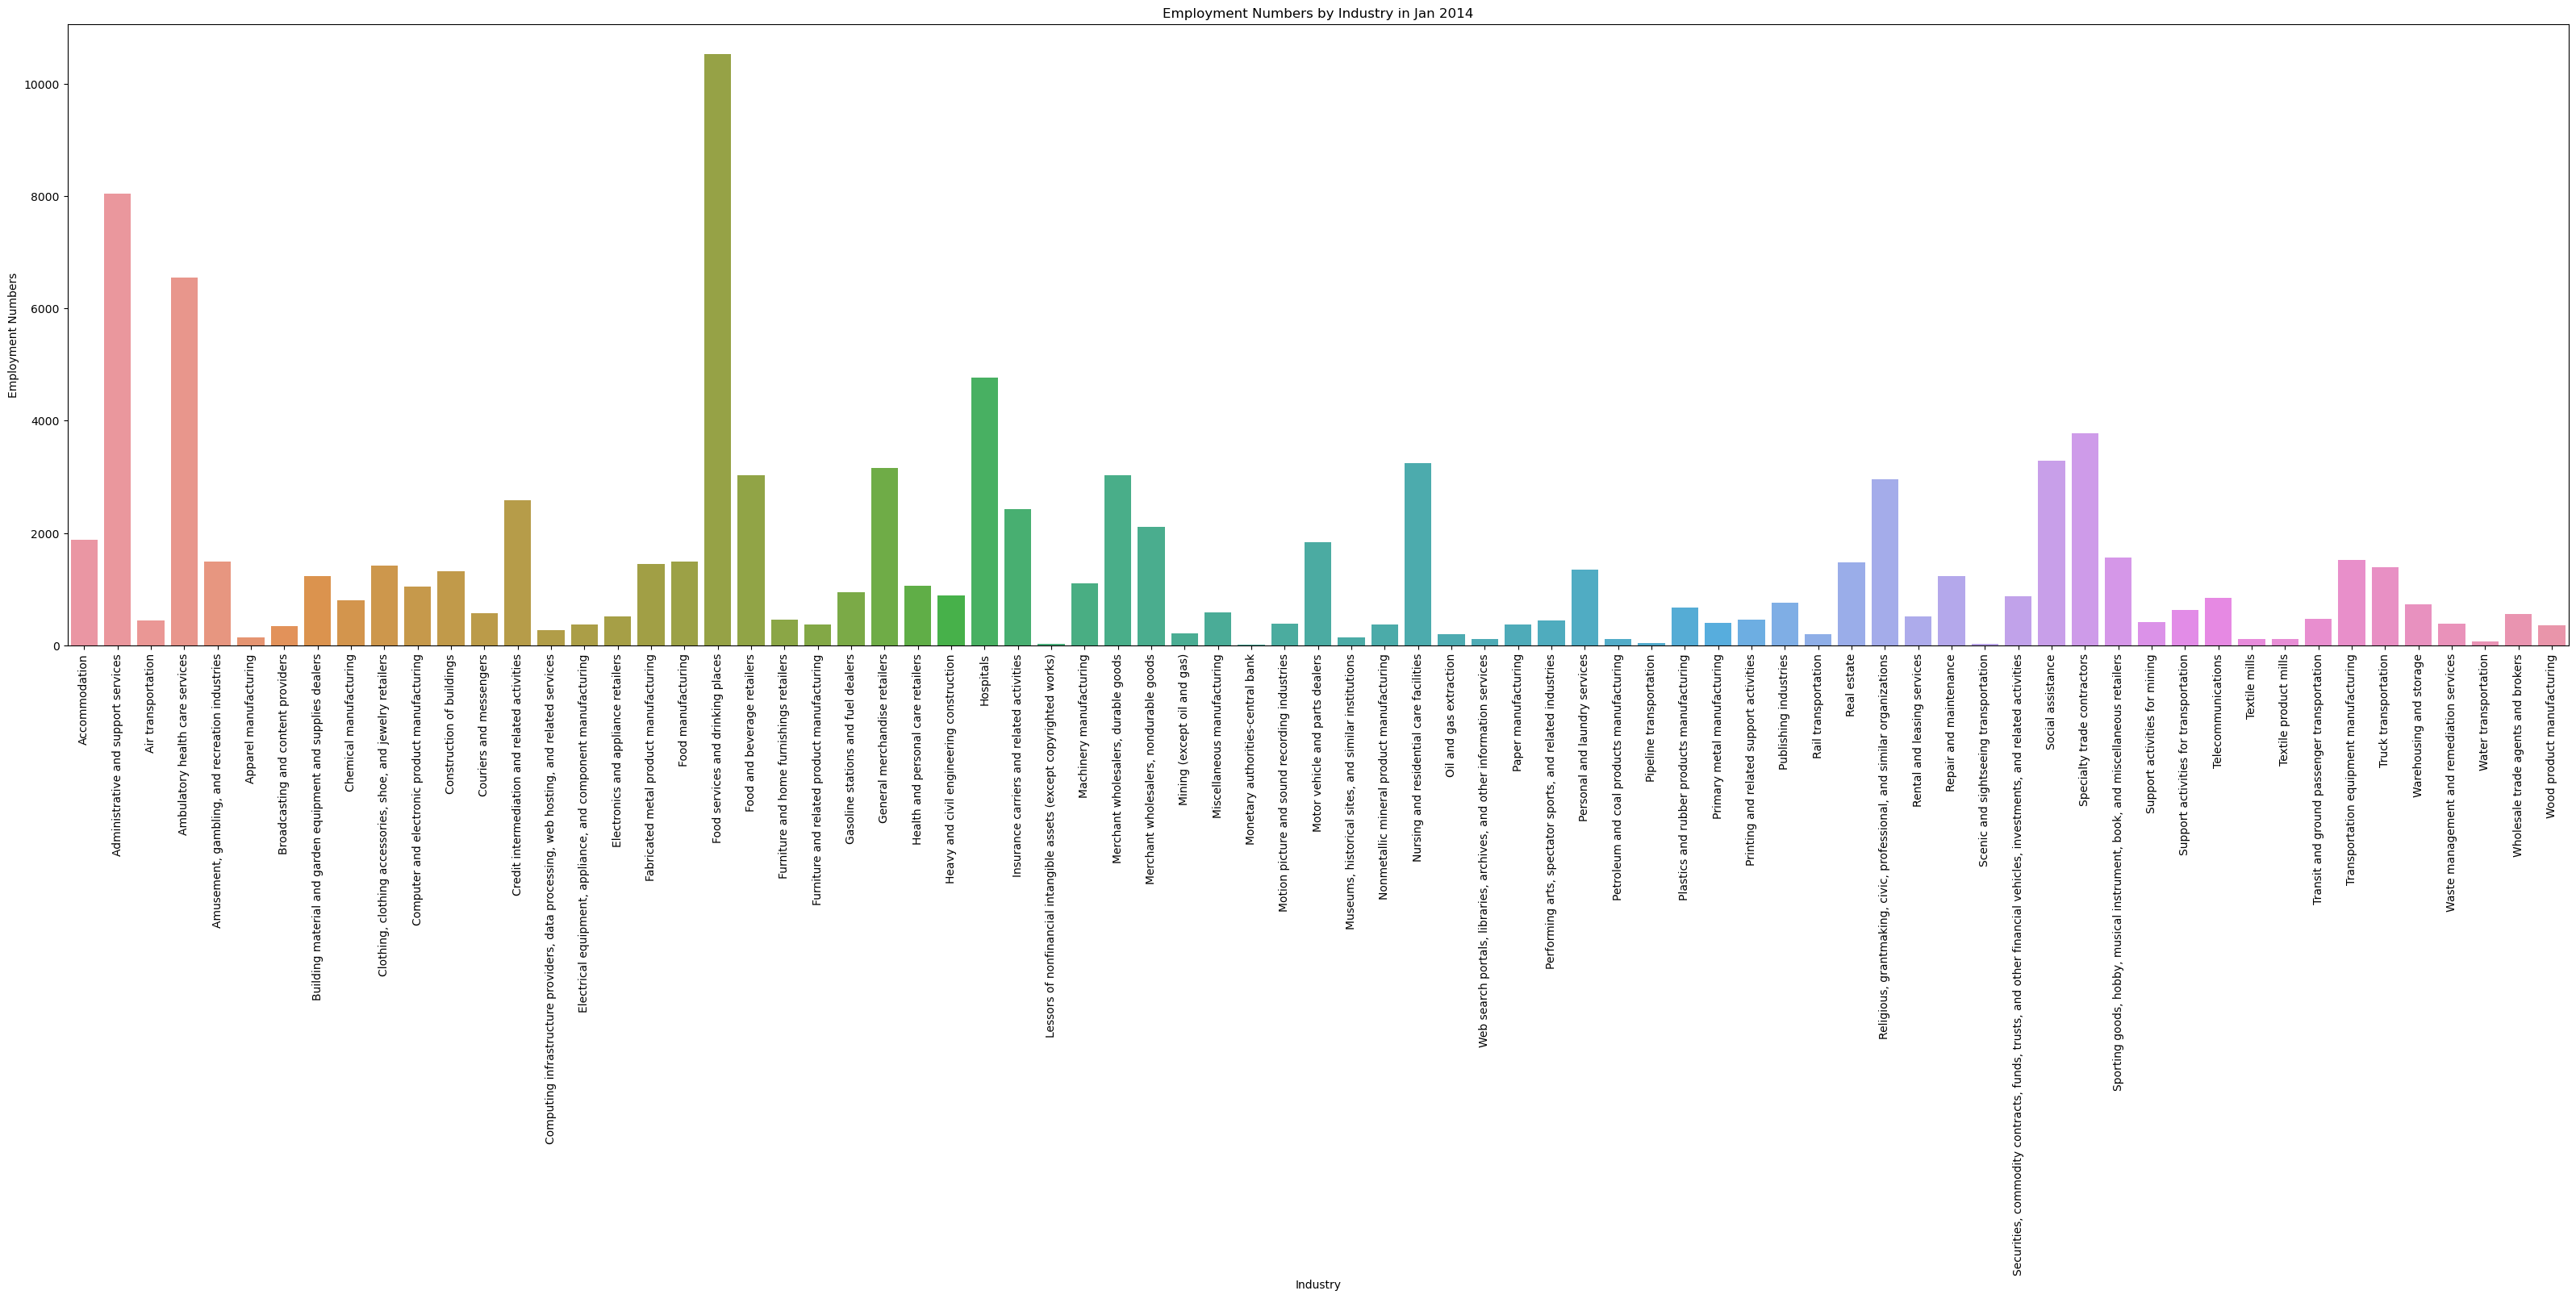

In [13]:
#January 2014
snapshot = industry_data[industry_data['Year-Month'] == '2014-01']
plt.figure(figsize=(40, 10))
plt.xticks(rotation=90)
sns.barplot(x='Industry', y='Value', data=snapshot)
plt.title('Employment Numbers by Industry in Jan 2014')
plt.xlabel('Industry')
plt.ylabel('Employment Numbers')
plt.savefig('/Users/shengmai/Desktop/winter2023-2024/141B/project/industry_bar_graph_2014.png',bbox_inches='tight', dpi=300)
plt.show()

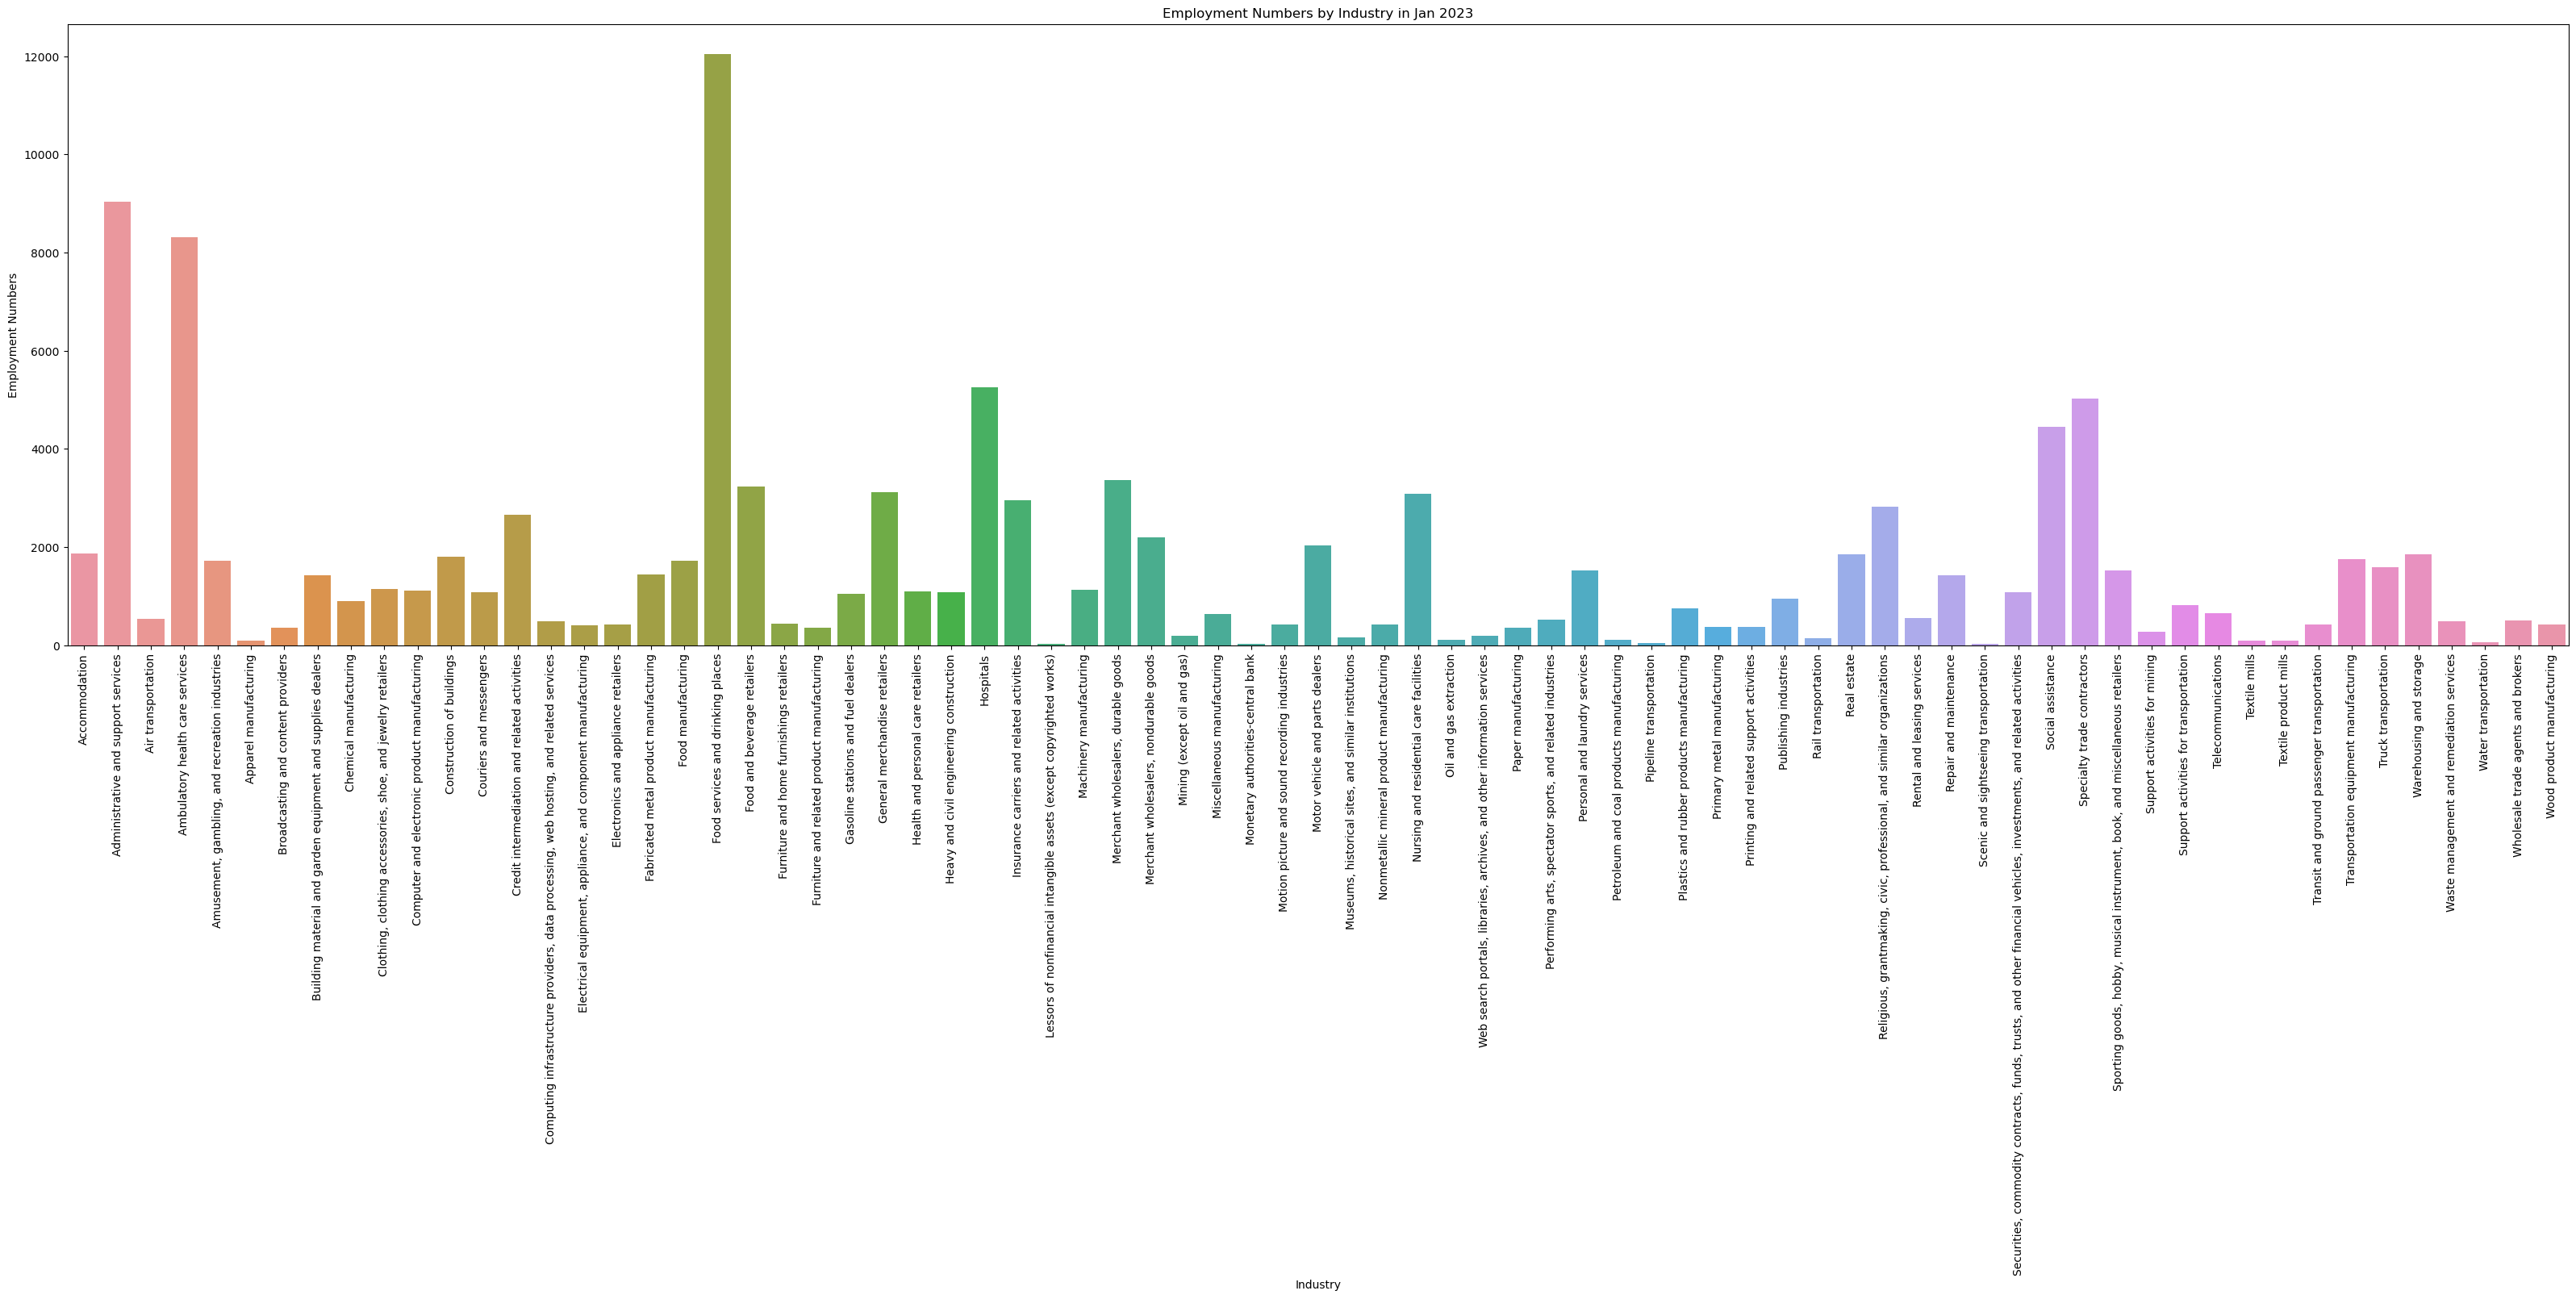

In [14]:
#January 2023
snapshot = industry_data[industry_data['Year-Month'] == '2023-01']
plt.figure(figsize=(40, 10))
plt.xticks(rotation=90)
sns.barplot(x='Industry', y='Value', data=snapshot)
plt.title('Employment Numbers by Industry in Jan 2023')
plt.xlabel('Industry')
plt.ylabel('Employment Numbers')
plt.savefig('/Users/shengmai/Desktop/winter2023-2024/141B/project/industry_bar_graph_2023.png',bbox_inches='tight', dpi=300)
plt.show()

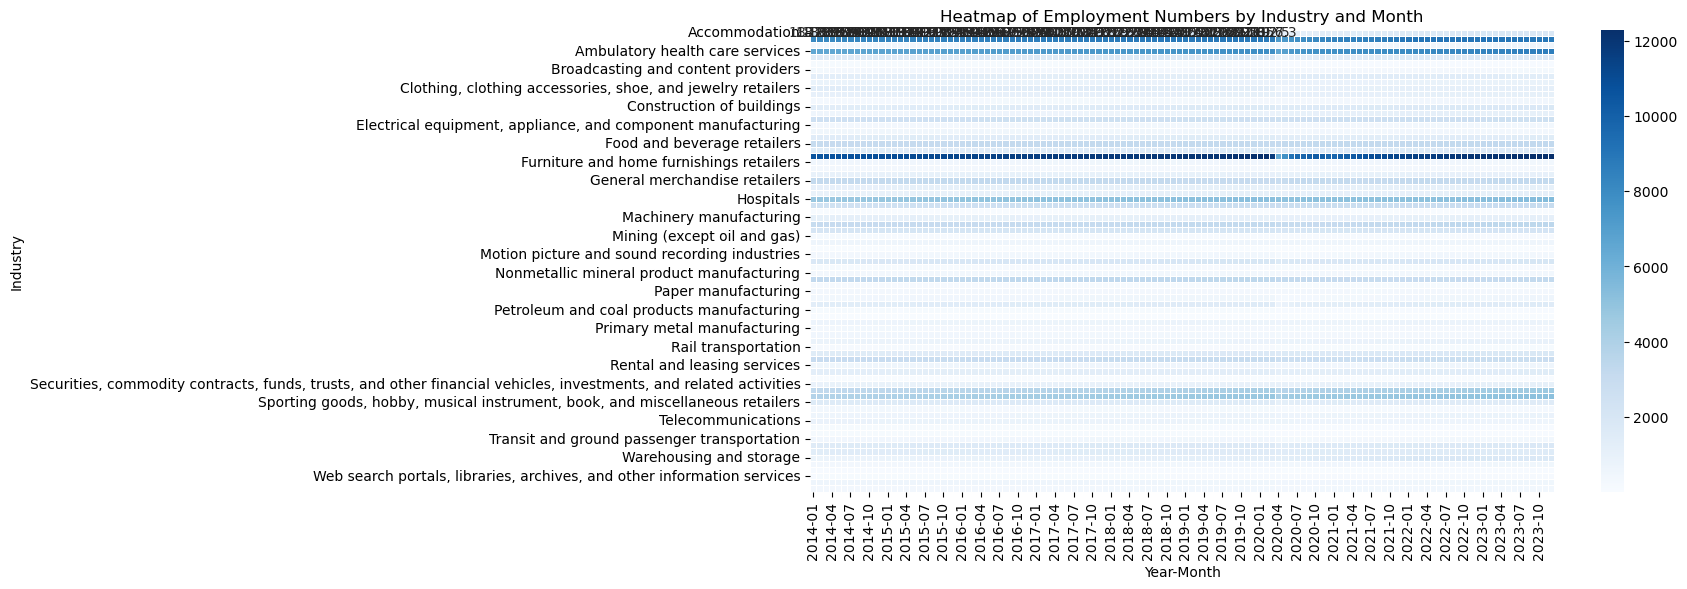

In [15]:
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_data, annot=True, fmt=".1f", linewidths=.5, cmap='Blues')
plt.title('Heatmap of Employment Numbers by Industry and Month')
plt.xlabel('Year-Month')
plt.ylabel('Industry')
#plt.savefig('/Users/shengmai/Desktop/winter2023-2024/141B/project/industry_heat_map.png',bbox_inches='tight', dpi=300)
plt.show()

additional visualization of bigger groups rather than specific industries

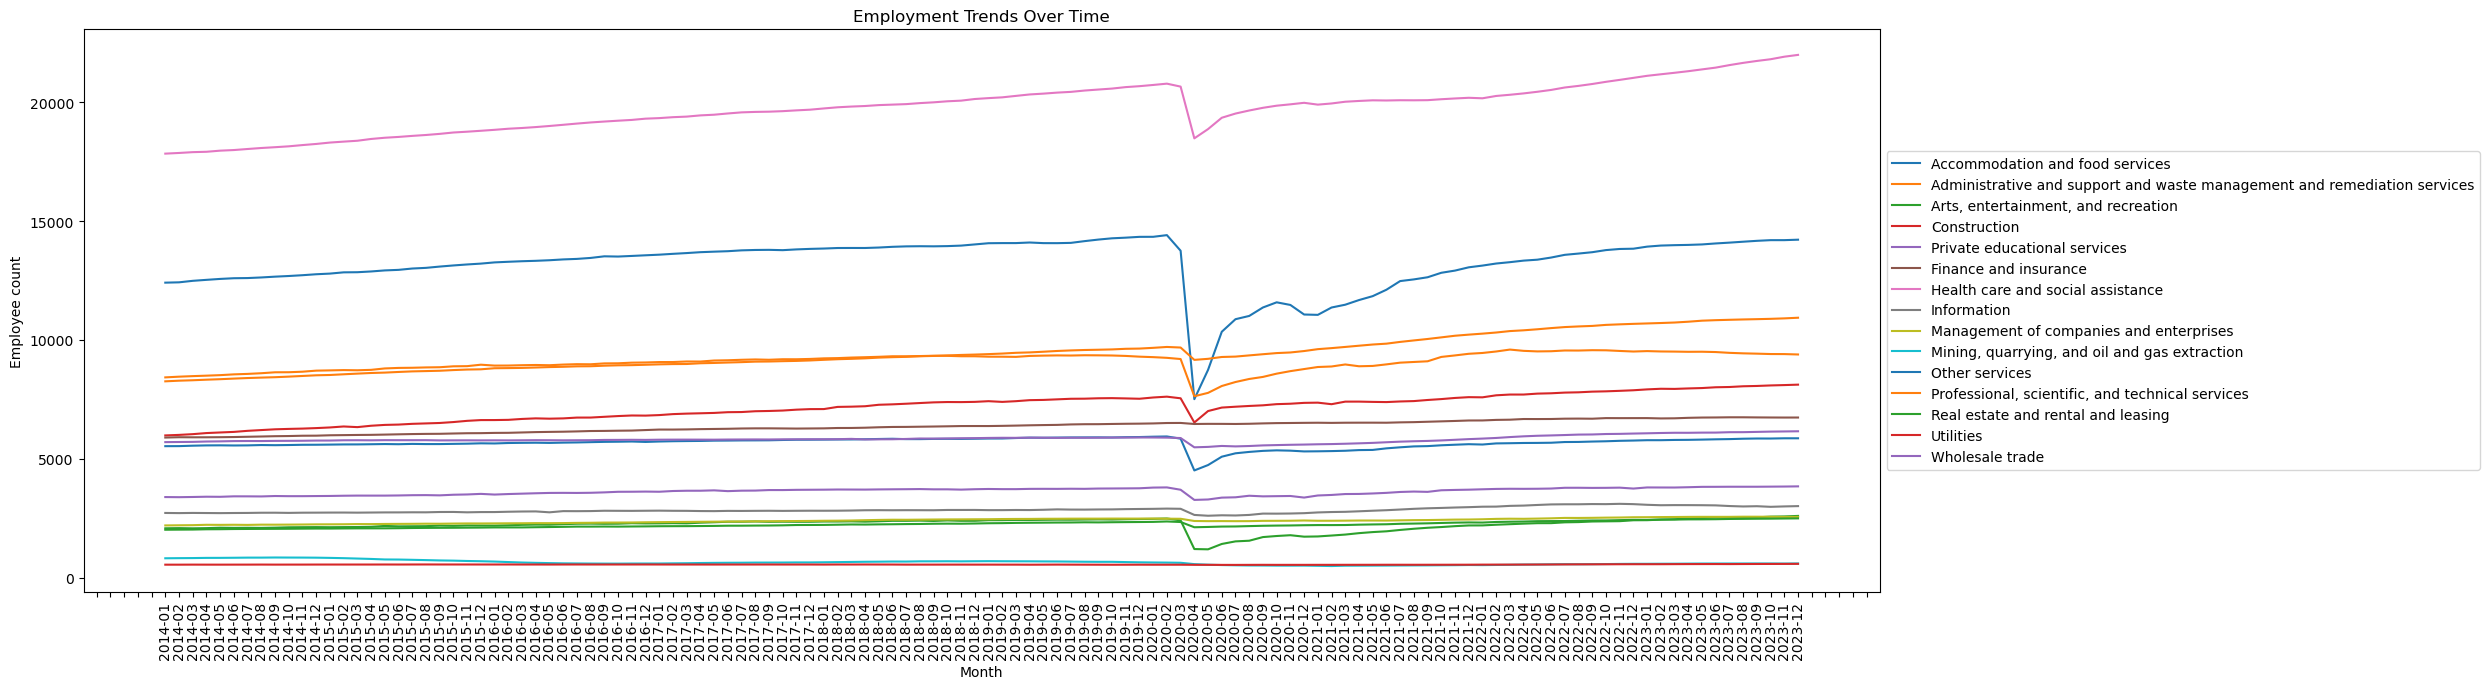

                            Industry  Year         Value
0    Accommodation and food services  2014  12589.816667
1    Accommodation and food services  2015  12989.583333
2    Accommodation and food services  2016  13408.700000
3    Accommodation and food services  2017  13729.541667
4    Accommodation and food services  2018  13916.416667
..                               ...   ...           ...
145                  Wholesale trade  2019   5888.133333
146                  Wholesale trade  2020   5632.541667
147                  Wholesale trade  2021   5709.191667
148                  Wholesale trade  2022   5979.175000
149                  Wholesale trade  2023   6115.908333

[150 rows x 3 columns]


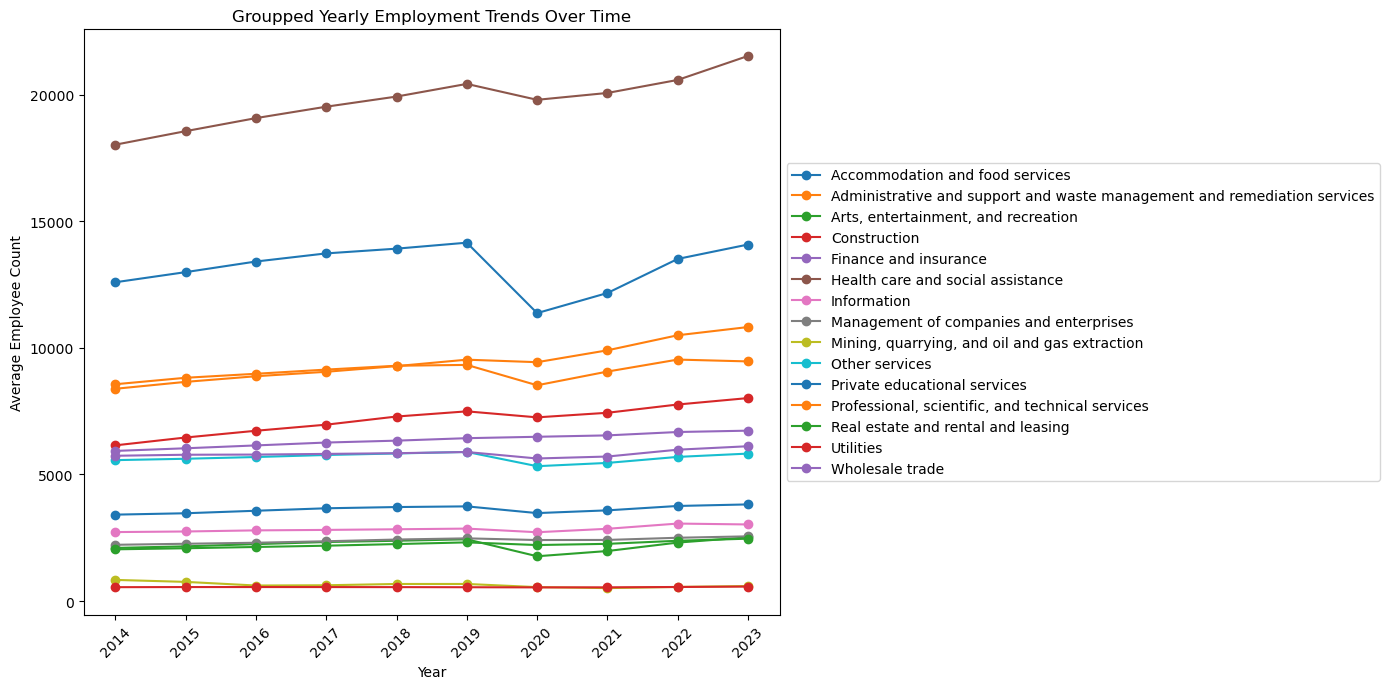

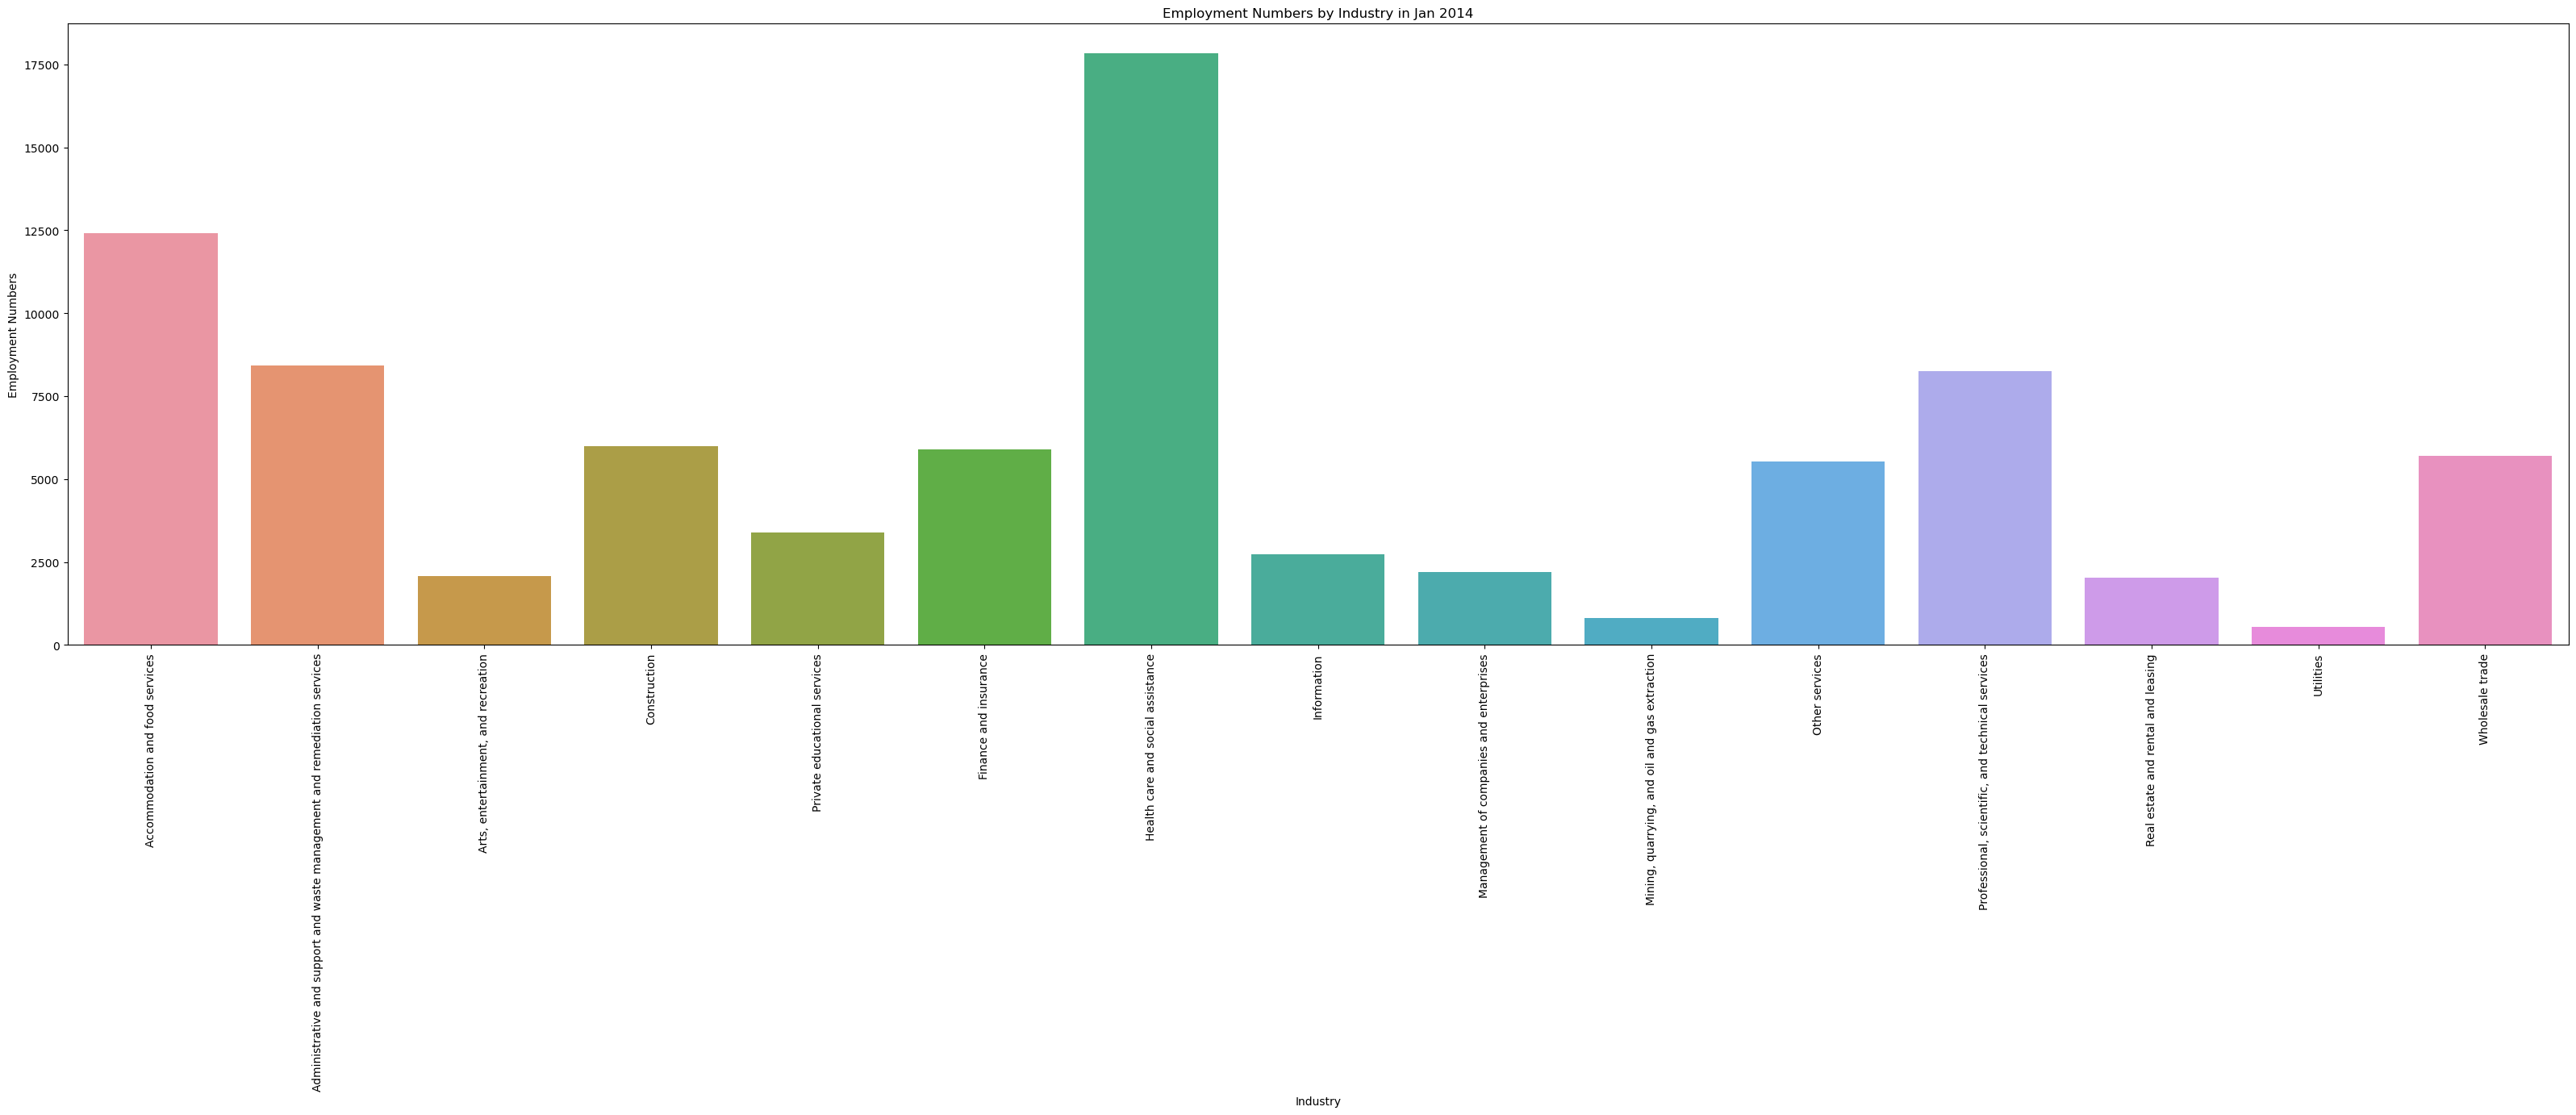

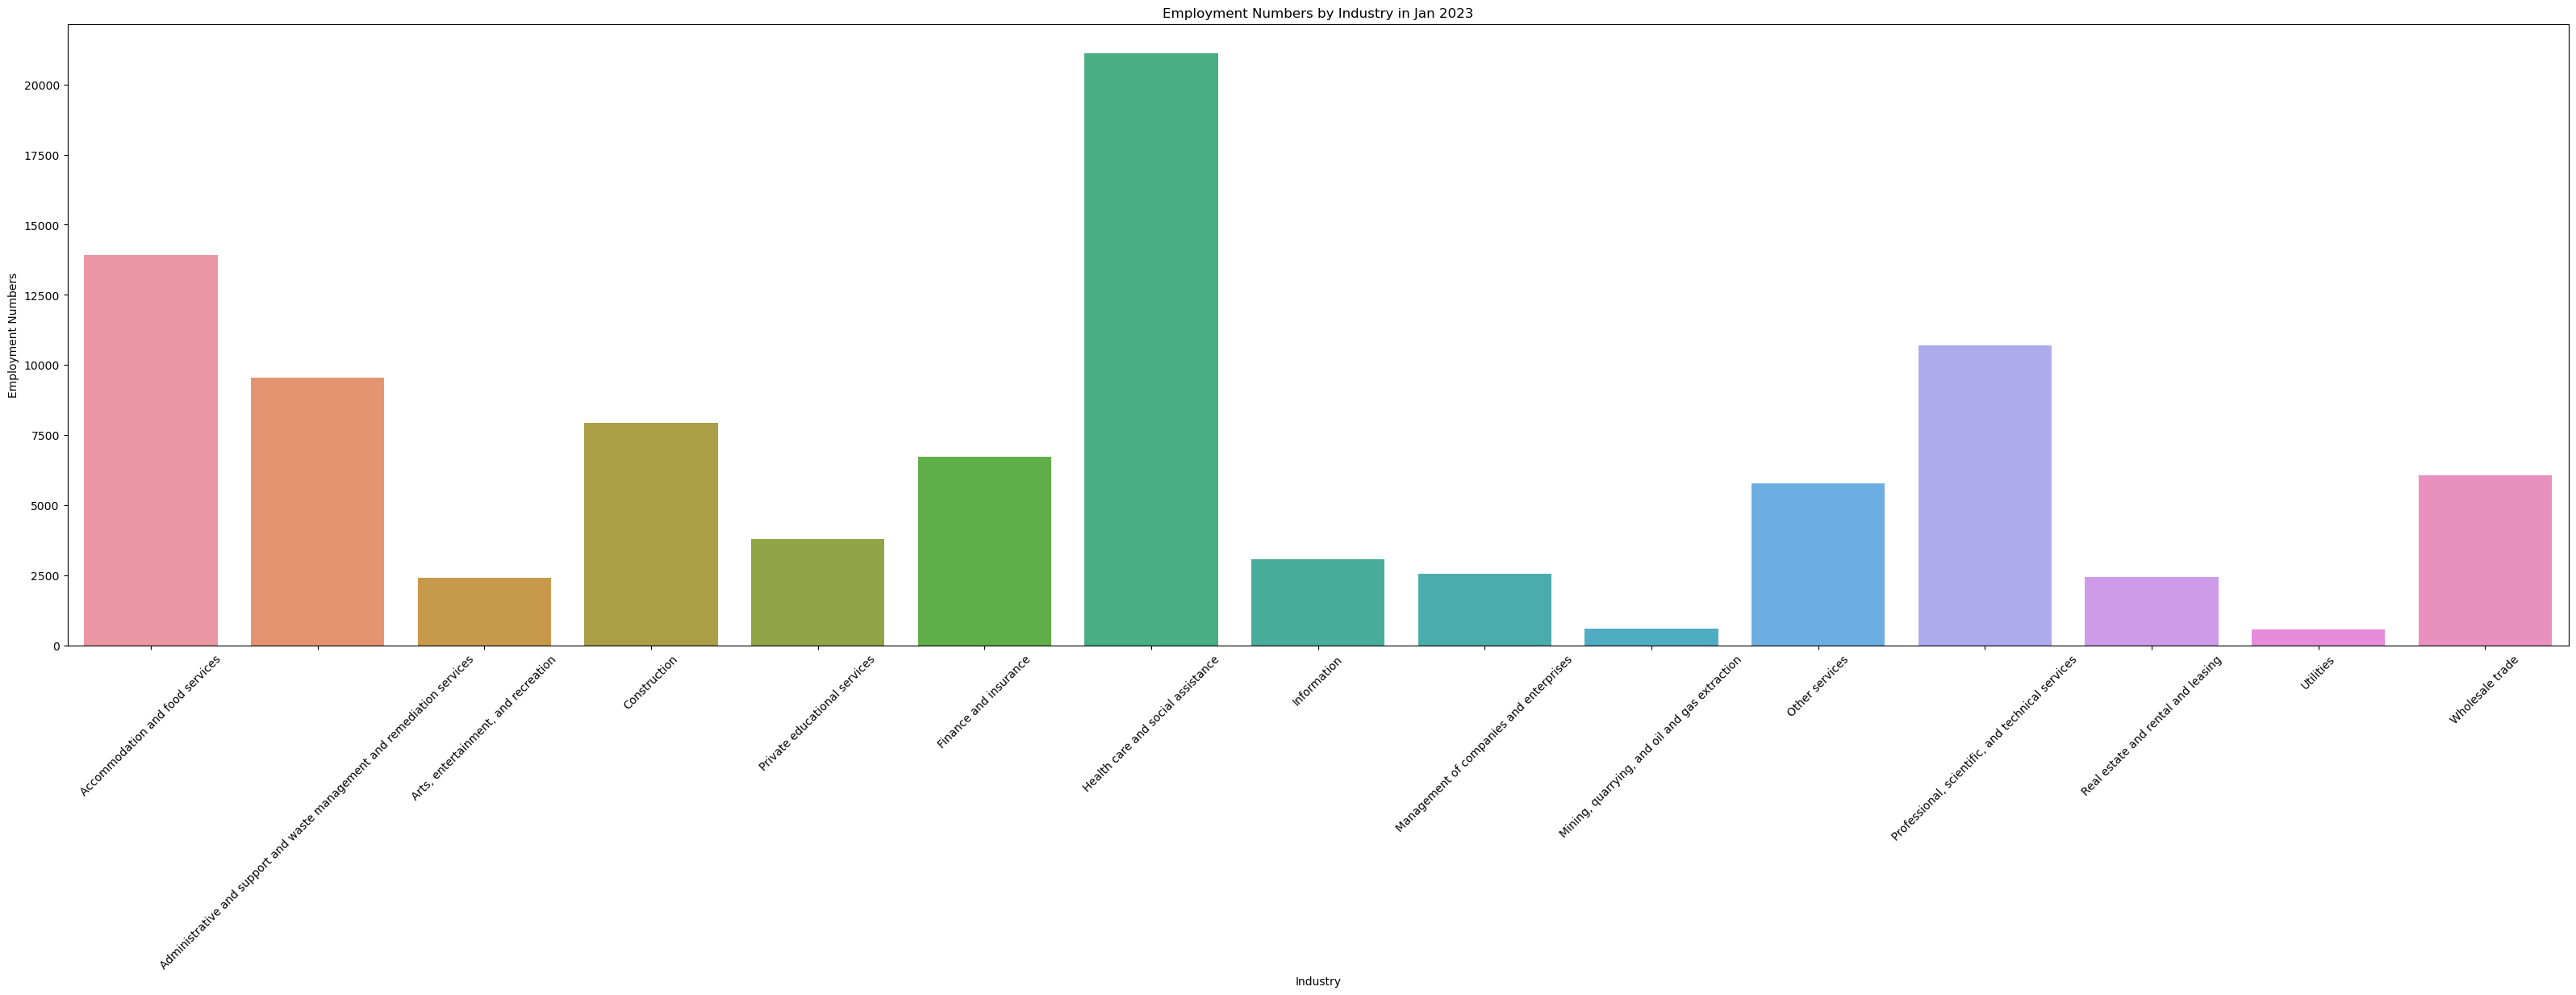

In [24]:
#sub_groupped - line monthly/line yearly/bar 2014 and bar 2023 

plt.figure(figsize=(25, 7))
for industry in sub_groupped_industry['Industry'].unique():
    industry_subset = sub_groupped_industry[sub_groupped_industry['Industry'] == industry]
    plt.plot(industry_subset['Year-Month'], industry_subset['Value'], marker='', label=industry)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.xticks(rotation=90)
plt.title('Employment Trends Over Time')
plt.xlabel('Month')
plt.ylabel('Employee count')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('/Users/shengmai/Desktop/winter2023-2024/141B/project/sub_groupped_line_graph_monthly.png', bbox_inches='tight', dpi = 300)
plt.show()

sub_groupped_industry['Year'] = pd.to_datetime(sub_groupped_industry['Year-Month']).dt.year
sub_yearly_data = sub_groupped_industry.groupby(['Industry', 'Year'])['Value'].mean().reset_index()
print(sub_yearly_data)
#line plot yearly
plt.figure(figsize=(14, 7))
for industry in sub_yearly_data['Industry'].unique():
    industry_subset = sub_yearly_data[sub_yearly_data['Industry'] == industry]
    plt.plot(industry_subset['Year'], industry_subset['Value'], marker='o', label=industry)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.xticks(rotation=45)
plt.title('Groupped Yearly Employment Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Average Employee Count')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('/Users/shengmai/Desktop/winter2023-2024/141B/project/sub_groupped_graph_yearly.png',bbox_inches='tight', dpi=300)
plt.show()


#January 2014
snapshot = sub_groupped_industry[sub_groupped_industry['Year-Month'] == '2014-01']
plt.figure(figsize=(40, 10))
plt.xticks(rotation=90)
sns.barplot(x='Industry', y='Value', data=snapshot)
plt.title('Employment Numbers by Industry in Jan 2014')
plt.xlabel('Industry')
plt.ylabel('Employment Numbers')
plt.savefig('/Users/shengmai/Desktop/winter2023-2024/141B/project/sub_groupped_bar_graph_2014.png',bbox_inches='tight', dpi=300)
plt.show()

# January 2023
snapshot = sub_groupped_industry[sub_groupped_industry['Year-Month'] == '2023-01']
plt.figure(figsize=(40, 10))
sns.barplot(x='Industry', y='Value', data=snapshot)
plt.xticks(rotation=45)
plt.title('Employment Numbers by Industry in Jan 2023')
plt.xlabel('Industry')
plt.ylabel('Employment Numbers')
plt.savefig('/Users/shengmai/Desktop/winter2023-2024/141B/project/sub_groupped_bar_graph_2023.png',bbox_inches='tight', dpi=300)
plt.show()


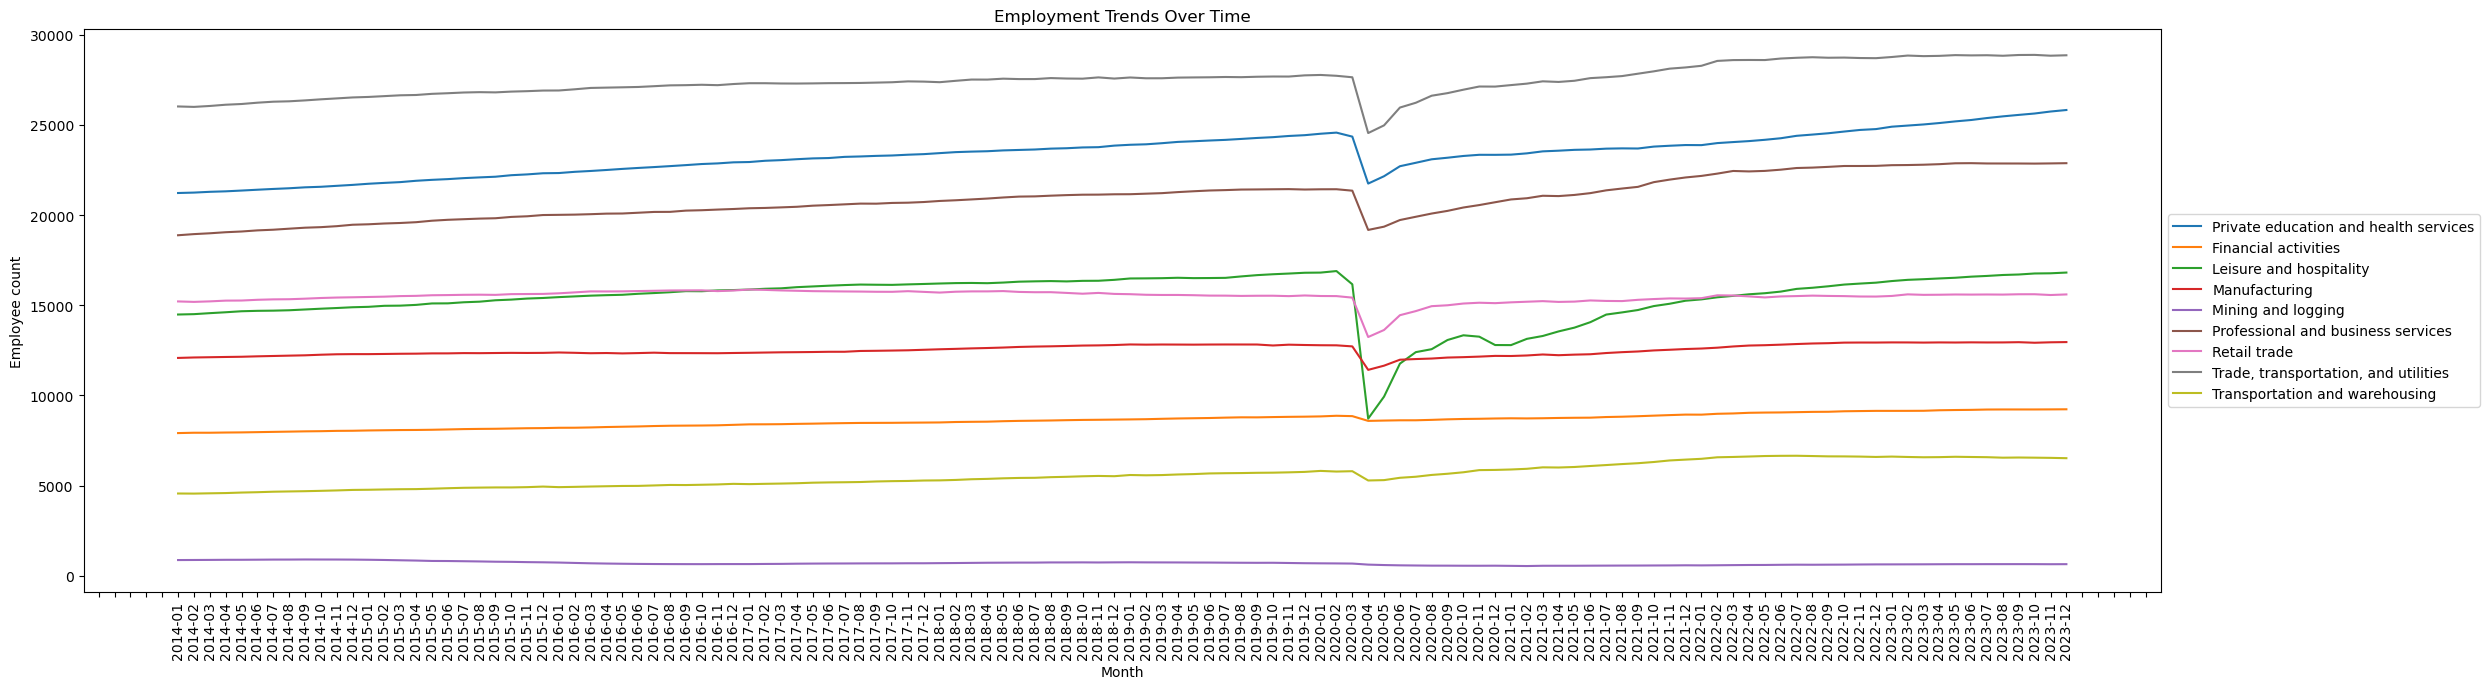

                          Industry  Year        Value
0             Financial activities  2014  7976.333333
1             Financial activities  2015  8123.083333
2             Financial activities  2016  8286.333333
3             Financial activities  2017  8450.333333
4             Financial activities  2018  8589.333333
..                             ...   ...          ...
85  Transportation and warehousing  2019  5665.266667
86  Transportation and warehousing  2020  5635.441667
87  Transportation and warehousing  2021  6140.375000
88  Transportation and warehousing  2022  6607.091667
89  Transportation and warehousing  2023  6568.833333

[90 rows x 3 columns]


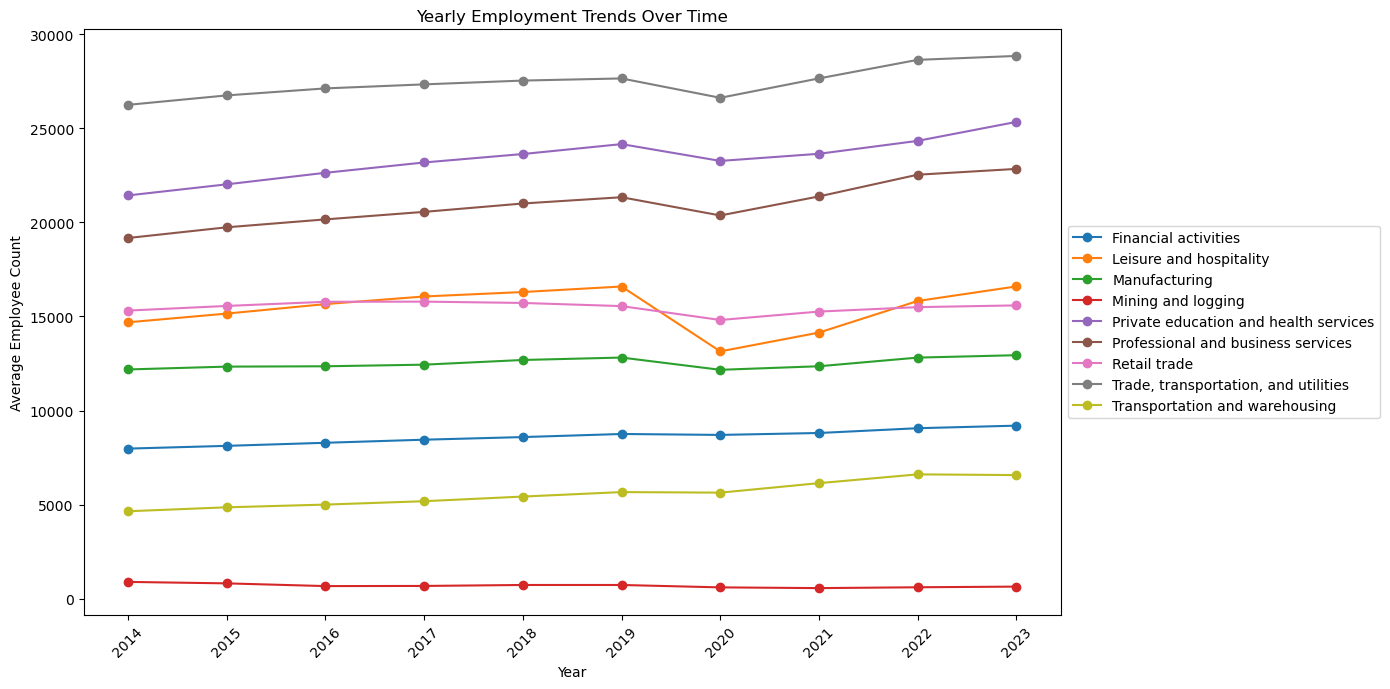

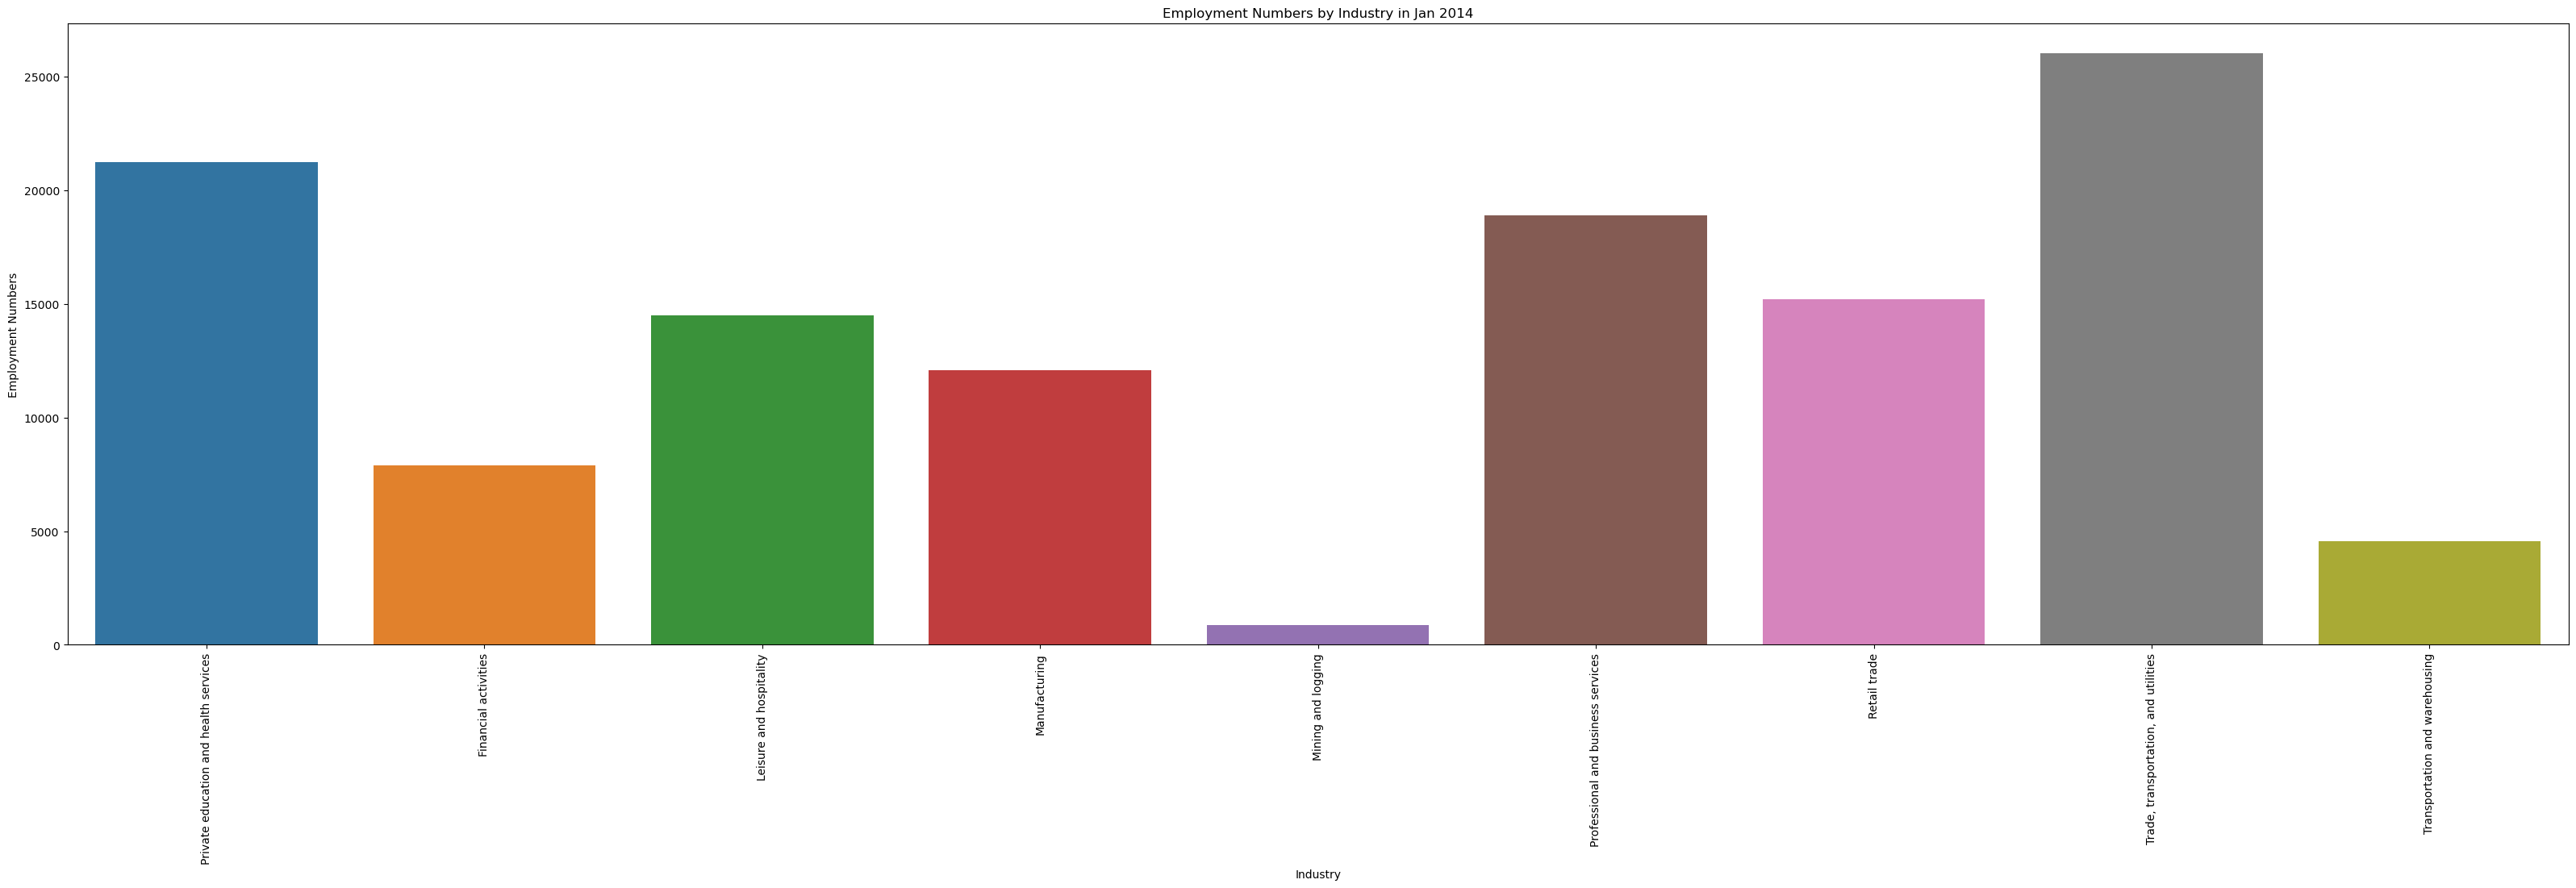

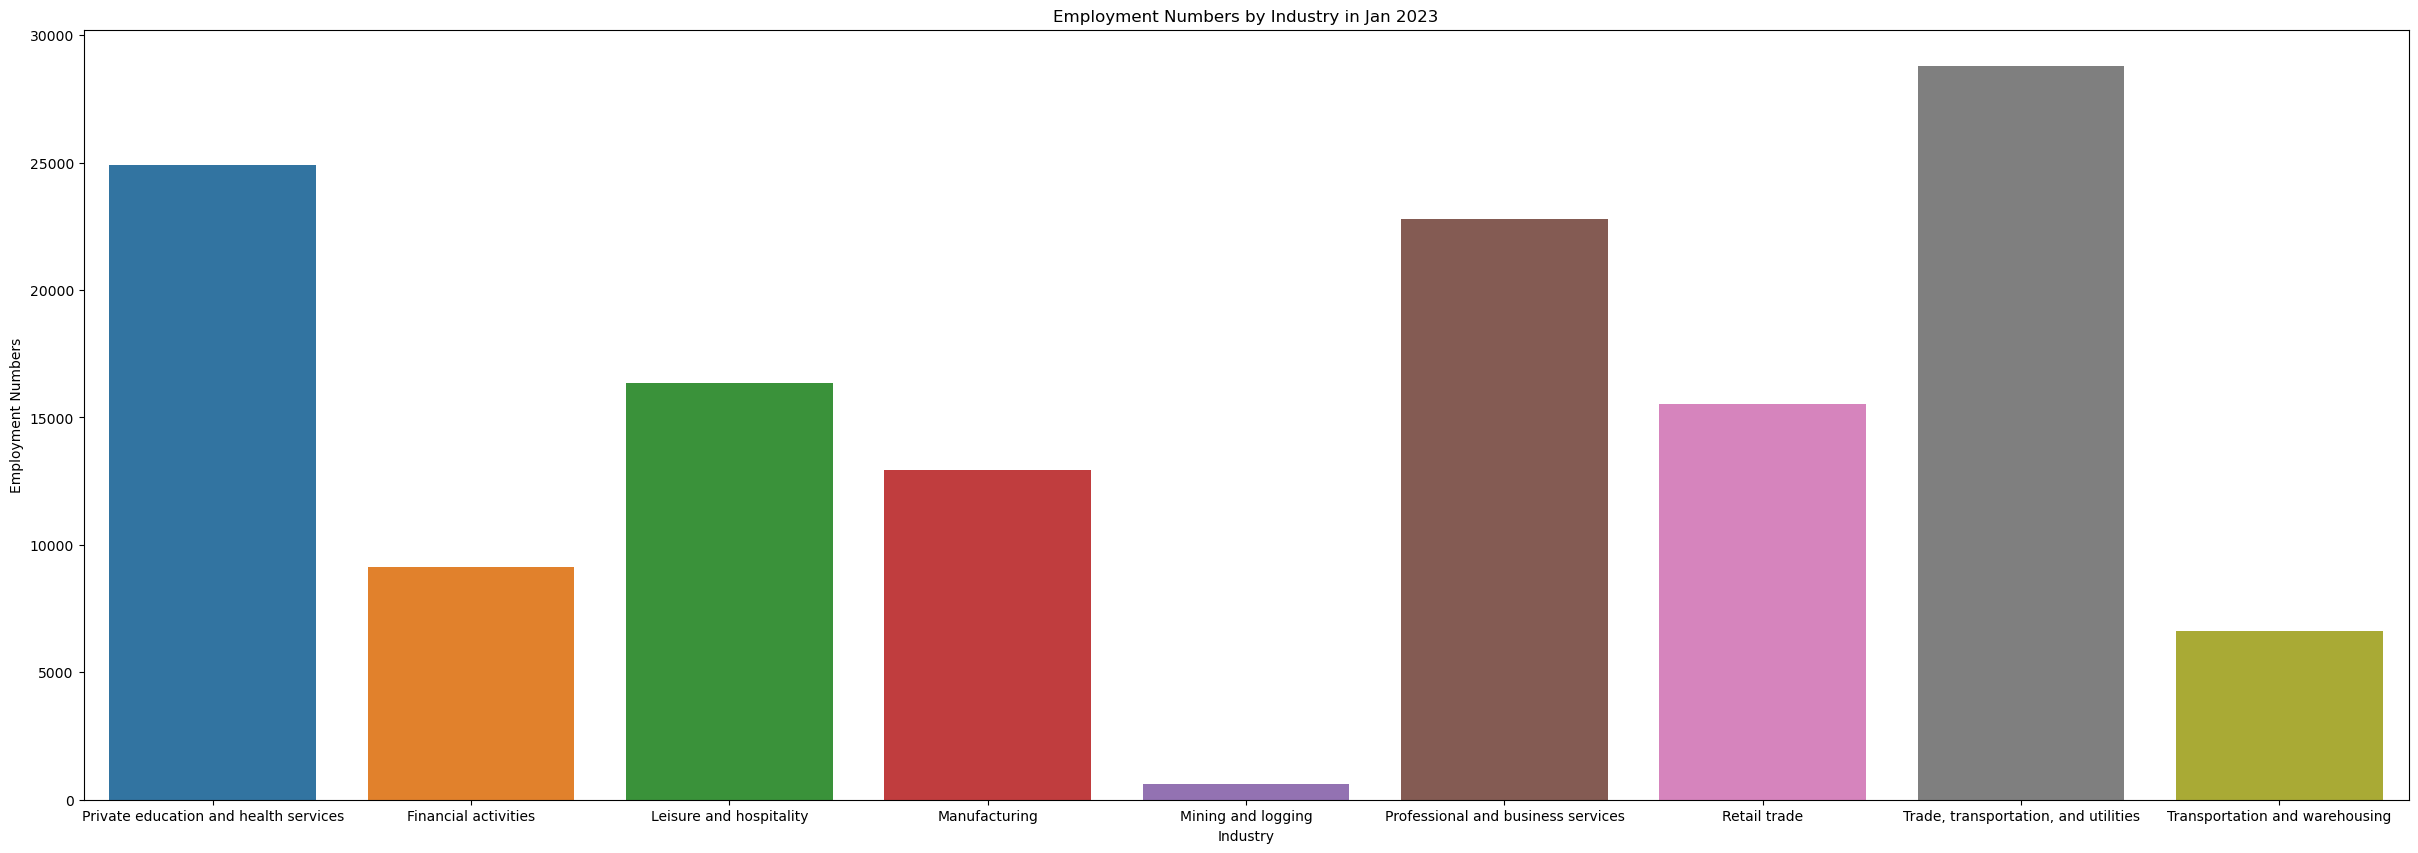

In [23]:
#main groupped - line monthly/line yearly/bar 2014 and bar 2023 

plt.figure(figsize=(25, 7))
for industry in main_groupped_industry['Industry'].unique():
    industry_subset = main_groupped_industry[main_groupped_industry['Industry'] == industry]
    plt.plot(industry_subset['Year-Month'], industry_subset['Value'], marker='', label=industry)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.xticks(rotation=90)
plt.title('Employment Trends Over Time')
plt.xlabel('Month')
plt.ylabel('Employee count')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('/Users/shengmai/Desktop/winter2023-2024/141B/project/main_groupped_line_graph_monthly.png', bbox_inches='tight', dpi = 300)
plt.show()

main_groupped_industry['Year'] = pd.to_datetime(main_groupped_industry['Year-Month']).dt.year
main_yearly_data = main_groupped_industry.groupby(['Industry', 'Year'])['Value'].mean().reset_index()
print(main_yearly_data)
#line plot yearly
plt.figure(figsize=(14, 7))
for industry in main_yearly_data['Industry'].unique():
    industry_subset = main_yearly_data[main_yearly_data['Industry'] == industry]
    plt.plot(industry_subset['Year'], industry_subset['Value'], marker='o', label=industry)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.xticks(rotation=45)
plt.title('Yearly Employment Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Average Employee Count')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('/Users/shengmai/Desktop/winter2023-2024/141B/project/main_groupped_line_graph_yearly.png',bbox_inches='tight', dpi=300)
plt.show()


#January 2014
snapshot = main_groupped_industry[main_groupped_industry['Year-Month'] == '2014-01']
plt.figure(figsize=(40, 10))
plt.xticks(rotation=90)
sns.barplot(x='Industry', y='Value', data=snapshot)
plt.title('Employment Numbers by Industry in Jan 2014')
plt.xlabel('Industry')
plt.ylabel('Employment Numbers')
plt.savefig('/Users/shengmai/Desktop/winter2023-2024/141B/project/main_groupped_bar_graph_2014.png',bbox_inches='tight', dpi=300)
plt.show()

#January 2023
snapshot = main_groupped_industry[main_groupped_industry['Year-Month'] == '2023-01']
plt.figure(figsize=(30, 10))
sns.barplot(x='Industry', y='Value', data=snapshot)
plt.title('Employment Numbers by Industry in Jan 2023')
plt.xlabel('Industry')
plt.ylabel('Employment Numbers')
plt.savefig('/Users/shengmai/Desktop/winter2023-2024/141B/project/main_groupped_bar_graph_2023.png',bbox_inches='tight', dpi=300)
plt.show()


find information from a different website
info regarding total income of each industry, group industries by this https://www.bls.gov/iag/tgs/iag_index_naics.htm
make a pie chart showing the distribution of profit in that industry, maybe make one for 2014 and one for 2023 to show the change
make a simple one and discuss how if someone were to pay me I can make additional exploration 


animated bar plot or maybe line plot, how do i do this, animated bar plot: x axis = industries, y axis = number of employees, every plot is data for one month, repeat for every month, this is learned from https://www.geeksforgeeks.org/how-to-create-animations-in-python/

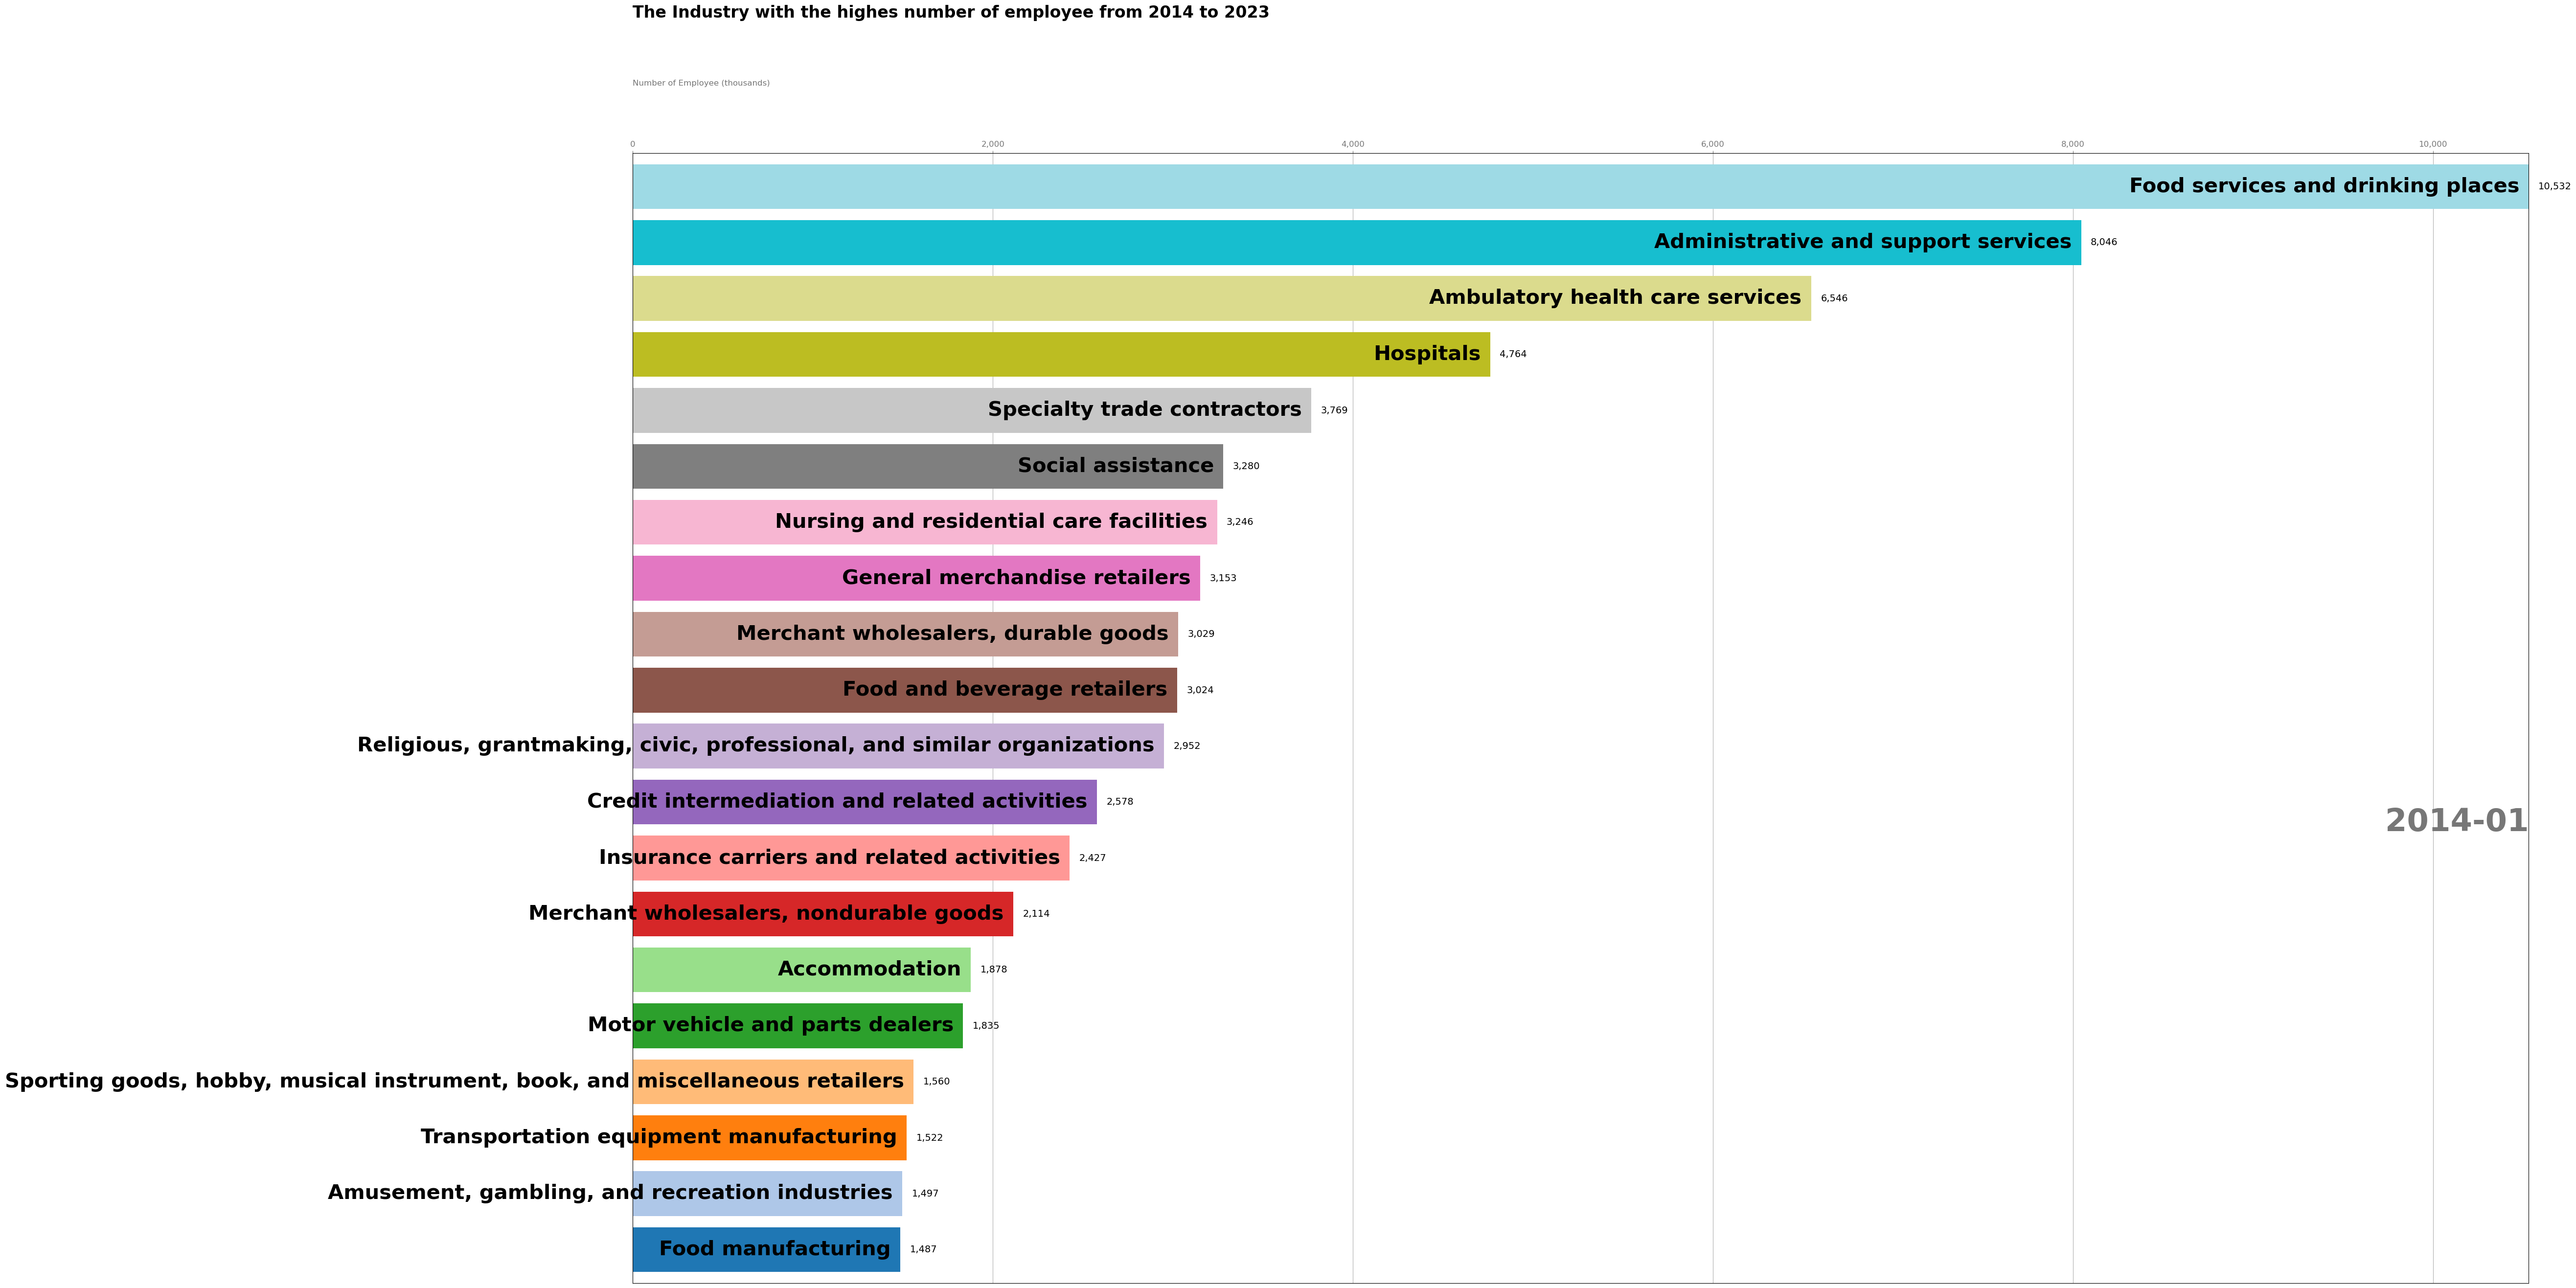

In [30]:
#this is learned from https://www.geeksforgeeks.org/how-to-create-animations-in-python/
#industry
def draw_barchart(year_month):
    #for each year, sort the data from low to high 
    dff = industry_data[industry_data['Year-Month'].eq(year_month)].sort_values(by='Value',ascending=True).tail(20)
    ax.clear()

    colors = plt.cm.tab20(np.linspace(0, 1, len(dff)))
    
    ax.barh(dff['Industry'], dff['Value'], color = colors)

    dx = dff['Value'].max() / 200
    for i, (value, name) in enumerate(zip(dff['Value'], dff['Industry'])):
        ax.text(value-dx, i, name, size=30, weight=600, ha='right', va='center')
        ax.text(value+dx, i, f'{value:,.0f}', size=14, ha='left',  va='center')
        
    ax.text(1, 0.4, year_month, transform=ax.transAxes, 
            color='#777777', size=46, ha='right',
            weight=800)
    ax.text(0, 1.06, 'Number of Employee (thousands)',
            transform=ax.transAxes, size=12,
            color='#777777')

    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    ax.text(0, 1.12, 'The Industry with the highes number of employee from 2014 to 2023',
            transform=ax.transAxes, size=24, weight=600, ha='left')

fig, ax = plt.subplots(figsize=(50, 30))
time_stamps = sorted(industry_data['Year-Month'].unique())
animator = FuncAnimation(fig, draw_barchart, frames=time_stamps)

animator.save('employment_trends_industry_monthly.gif', writer='pillow', fps=12)

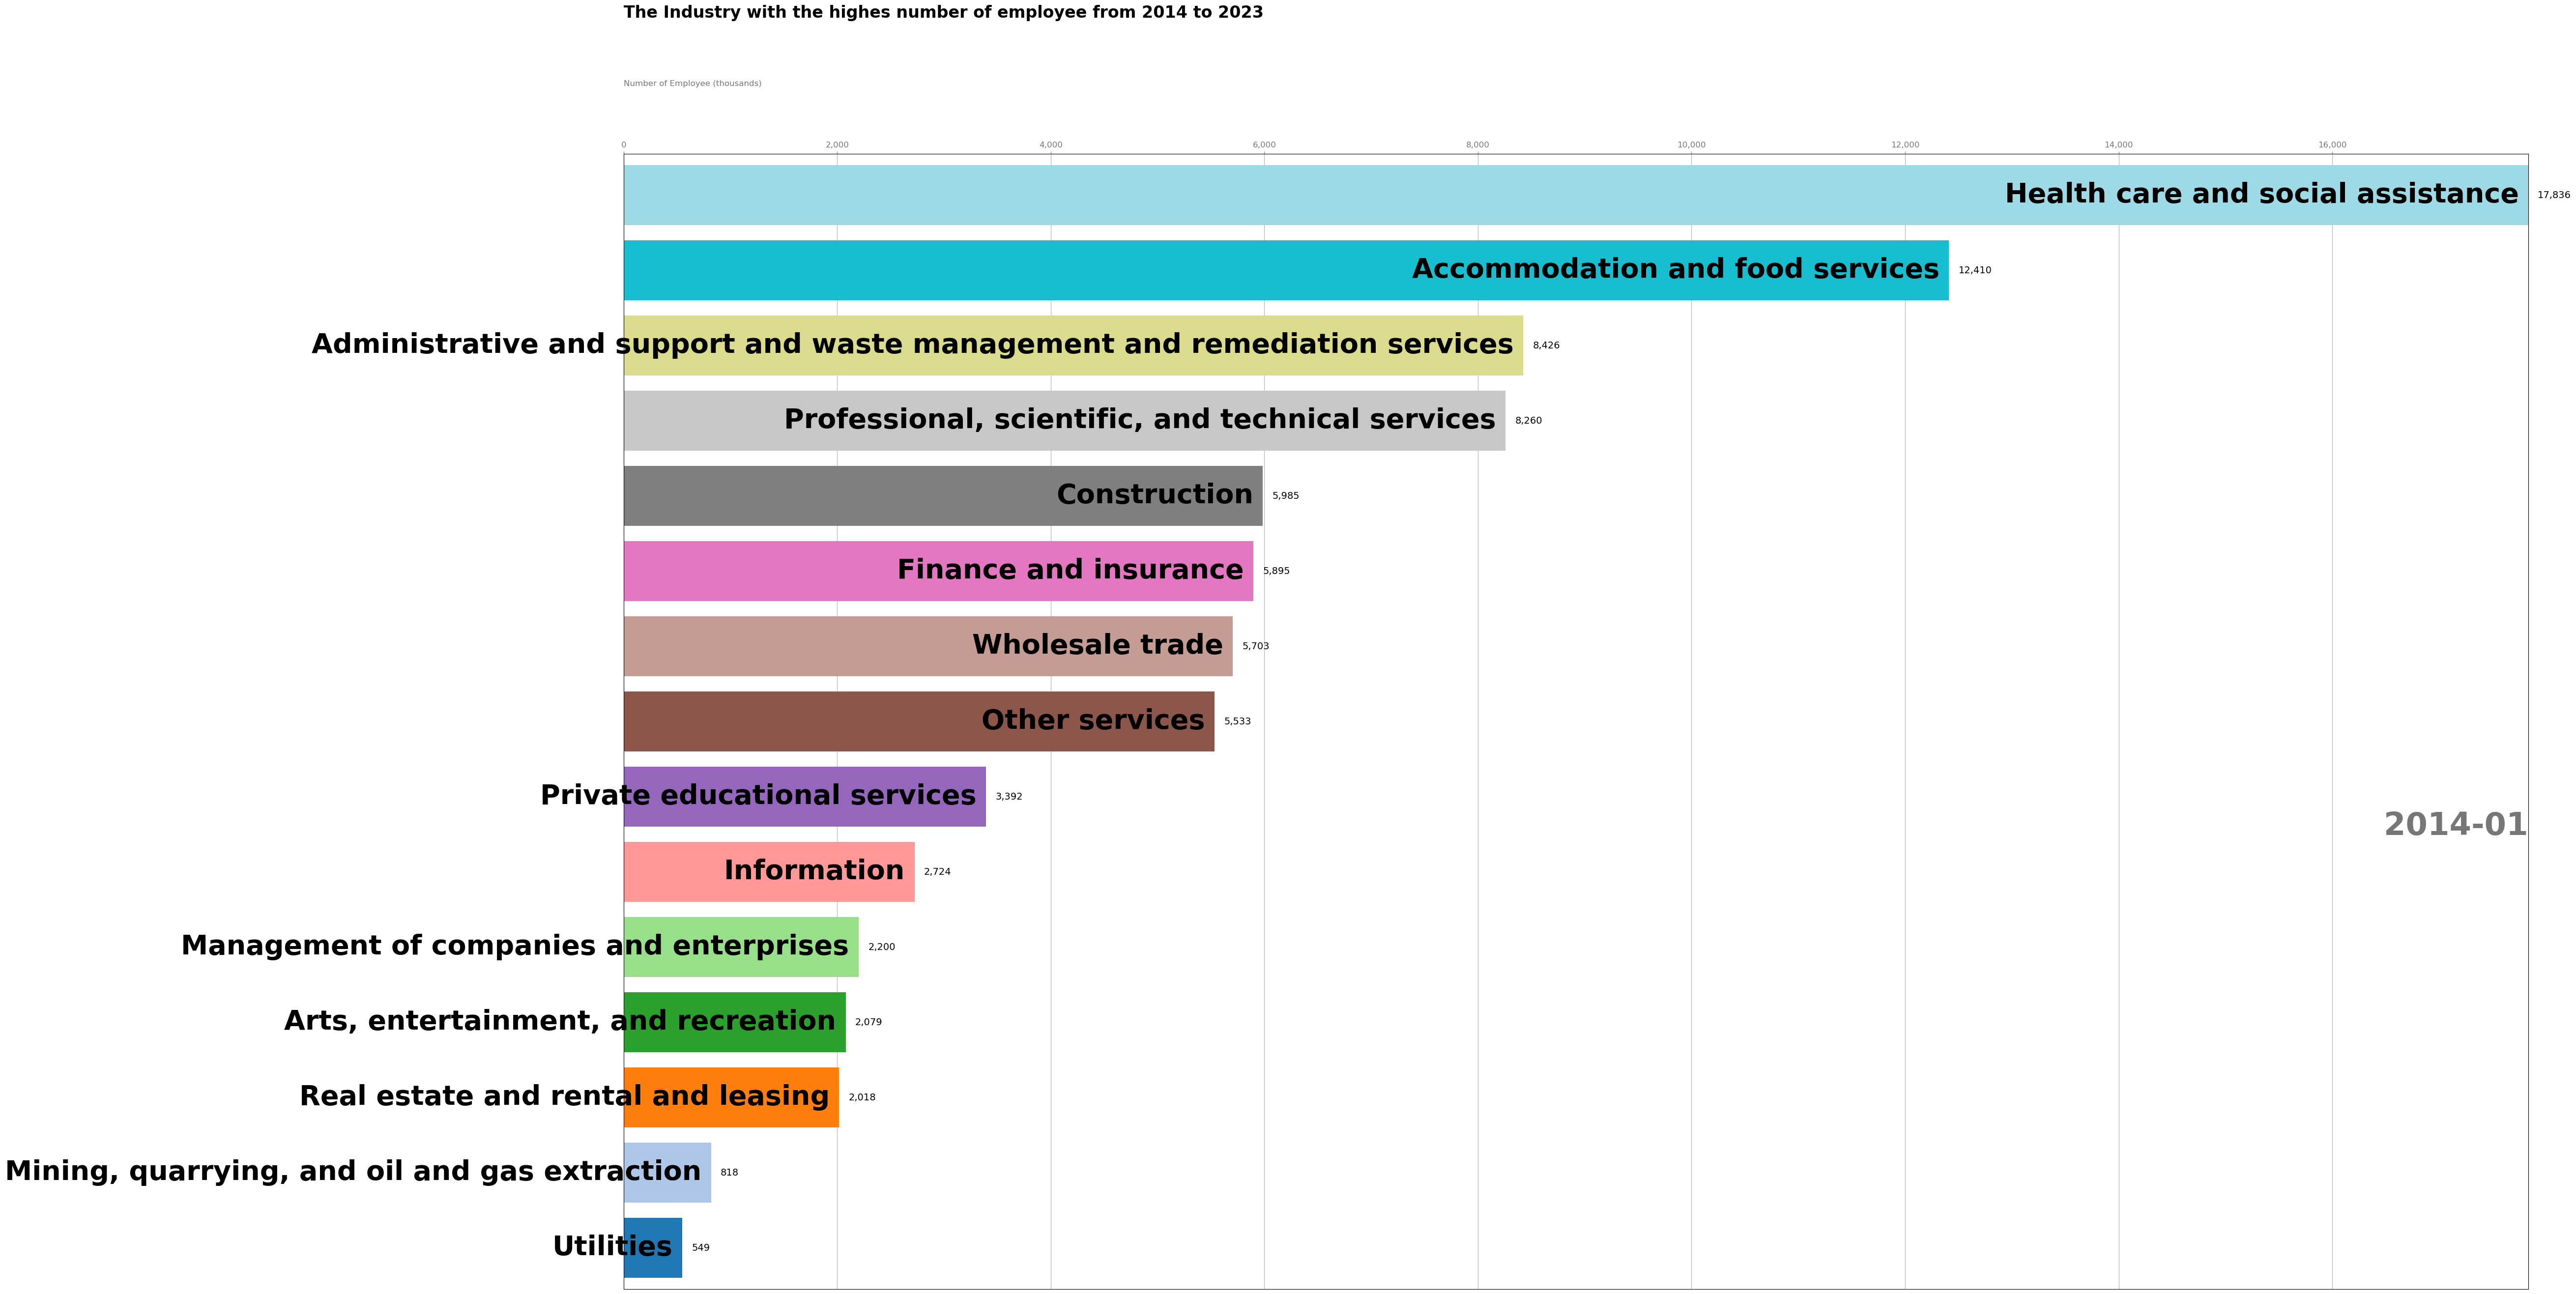

In [28]:
#sub groupped

def draw_barchart(year_month):
    #for each year, sort the data from low to high 
    dff = sub_groupped_industry[sub_groupped_industry['Year-Month'].eq(year_month)].sort_values(by='Value',ascending=True).tail(20)
    ax.clear()

    colors = plt.cm.tab20(np.linspace(0, 1, len(dff)))
    
    ax.barh(dff['Industry'], dff['Value'], color = colors)

    dx = dff['Value'].max() / 200
    for i, (value, name) in enumerate(zip(dff['Value'], dff['Industry'])):
        ax.text(value-dx, i, name, size=40, weight=600, ha='right', va='center')
        ax.text(value+dx, i, f'{value:,.0f}', size=14, ha='left',  va='center')
        
    ax.text(1, 0.4, year_month, transform=ax.transAxes, 
            color='#777777', size=46, ha='right',
            weight=800)
    ax.text(0, 1.06, 'Number of Employee (thousands)',
            transform=ax.transAxes, size=12,
            color='#777777')

    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    ax.text(0, 1.12, 'The Industry with the highes number of employee from 2014 to 2023',
            transform=ax.transAxes, size=24, weight=600, ha='left')

fig, ax = plt.subplots(figsize=(50, 30))
time_stamps = sorted(sub_groupped_industry['Year-Month'].unique())
animator = FuncAnimation(fig, draw_barchart, frames=time_stamps)

animator.save('employment_trends_subgroup_monthly.gif', writer='pillow', fps=12)


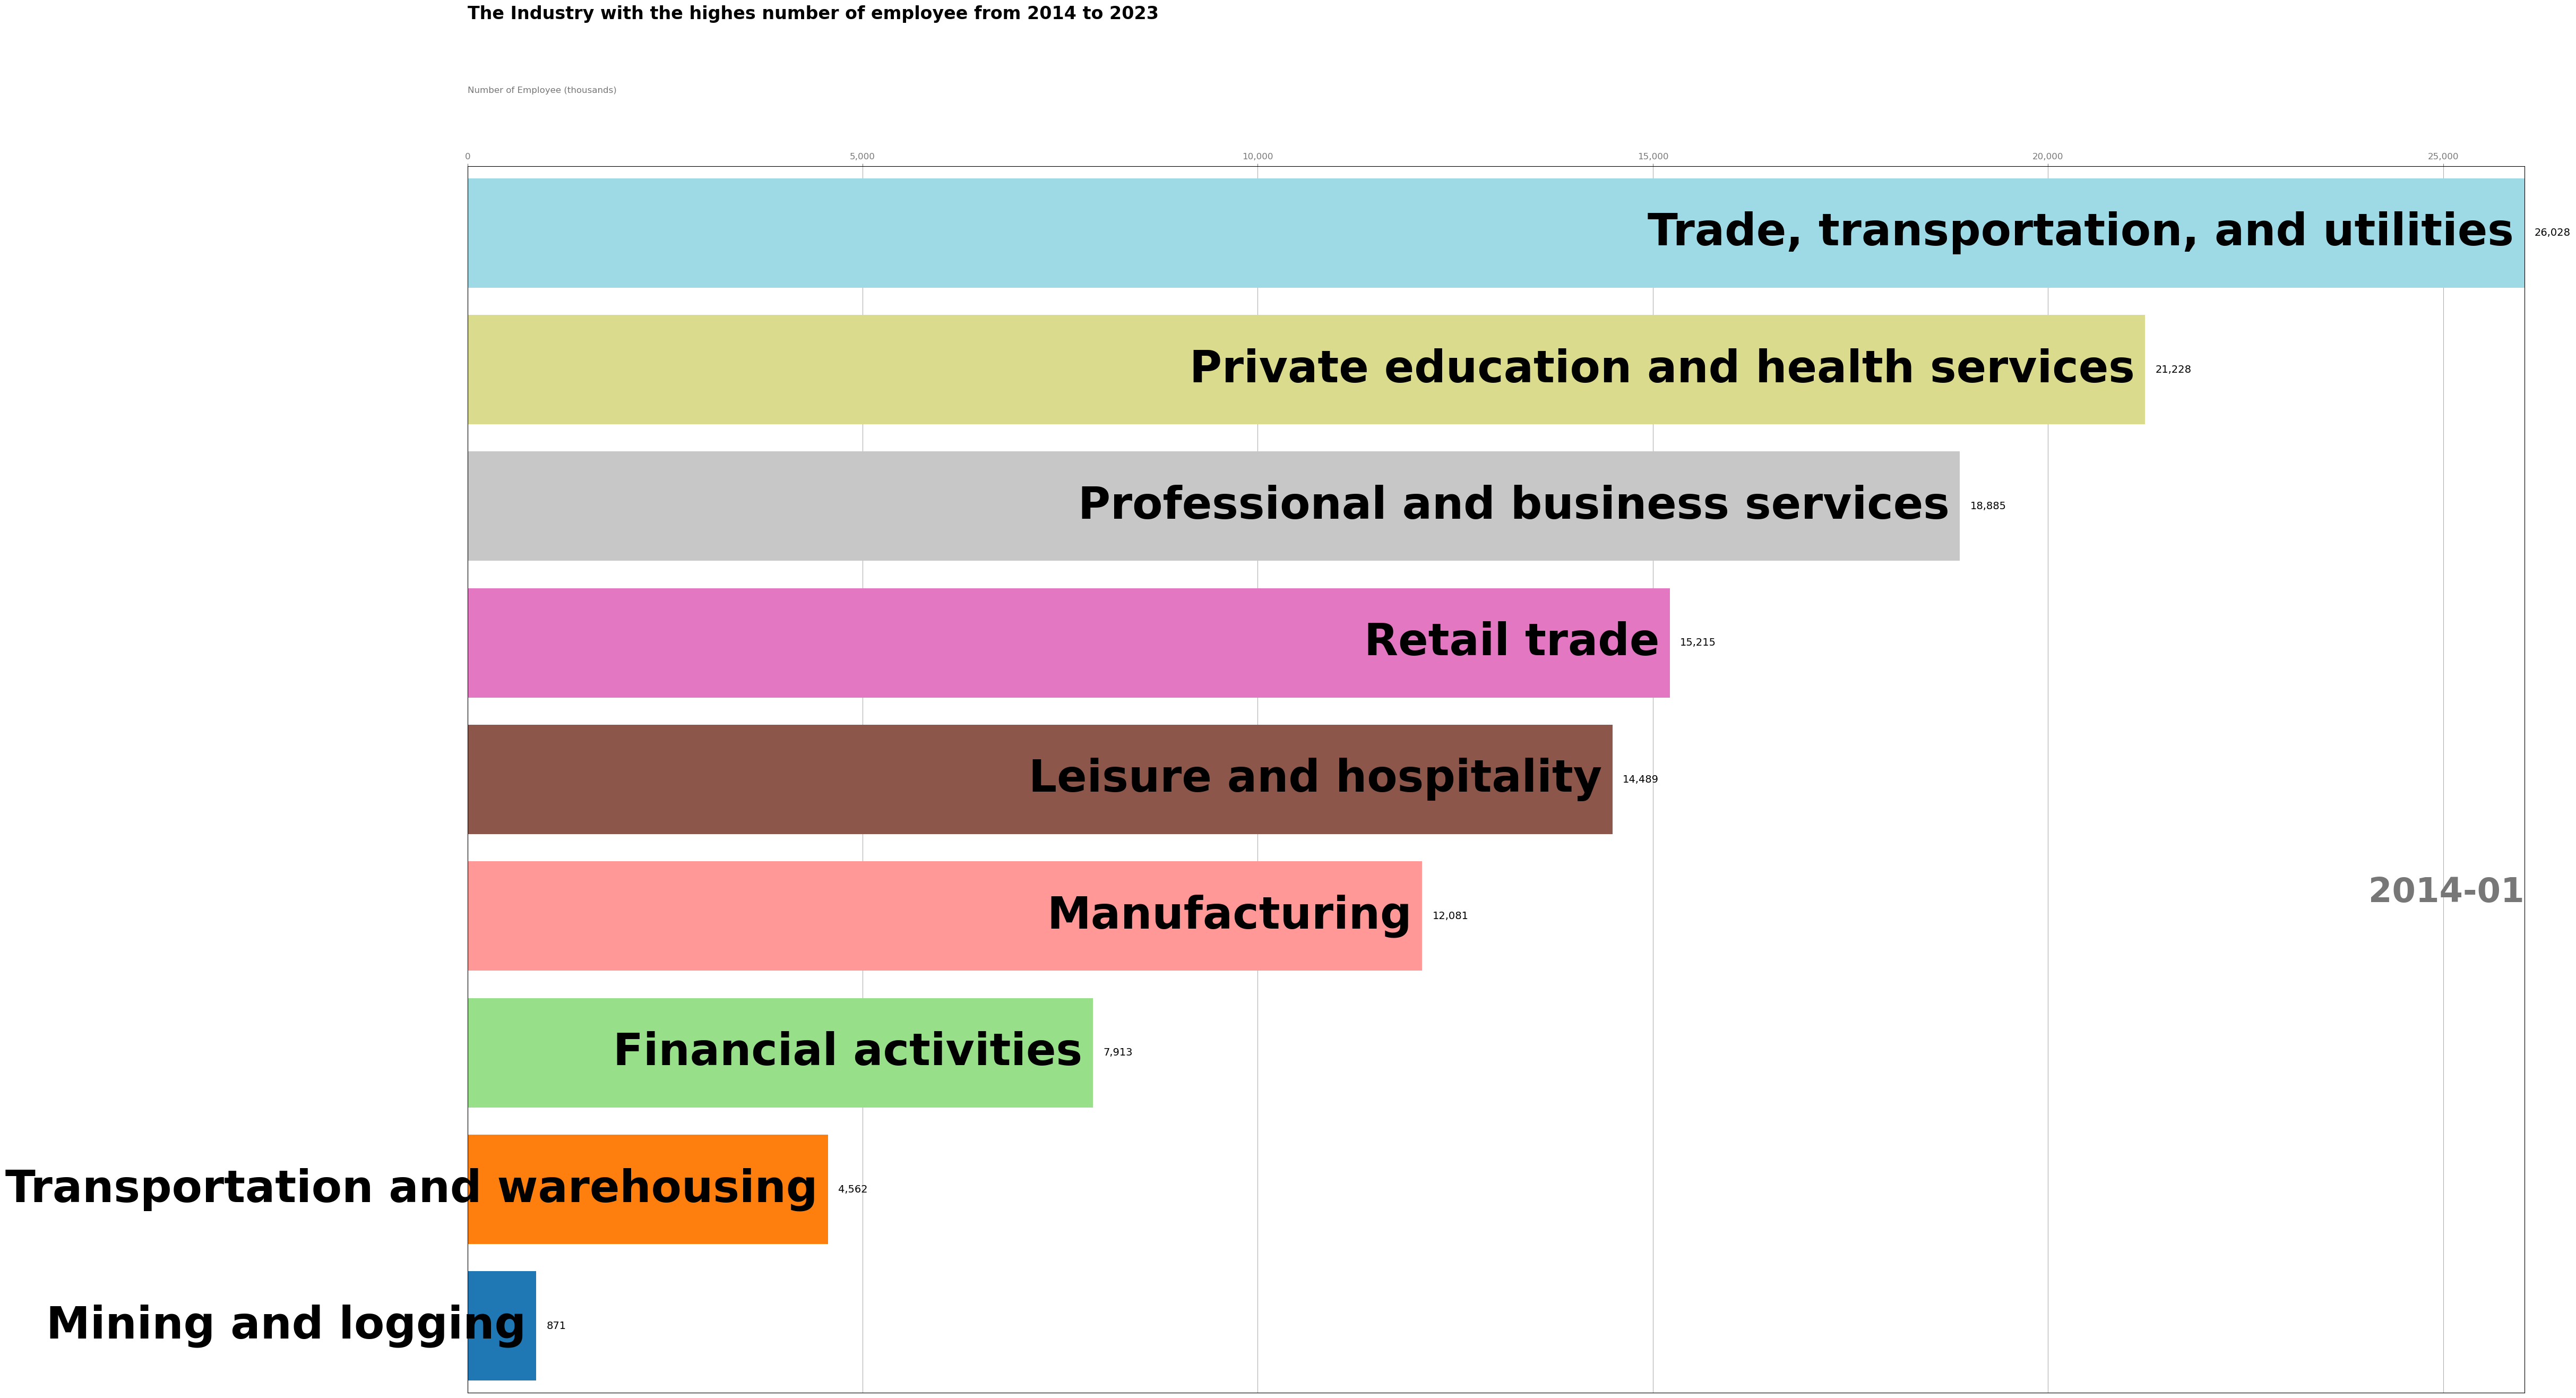

In [31]:
#main groupped
def draw_barchart(year_month):
    #for each year, sort the data from low to high 
    dff = main_groupped_industry[main_groupped_industry['Year-Month'].eq(year_month)].sort_values(by='Value',ascending=True).tail(20)
    ax.clear()

    colors = plt.cm.tab20(np.linspace(0, 1, len(dff)))
    
    ax.barh(dff['Industry'], dff['Value'], color = colors)

    dx = dff['Value'].max() / 200
    for i, (value, name) in enumerate(zip(dff['Value'], dff['Industry'])):
        ax.text(value-dx, i, name, size=60, weight=600, ha='right', va='center')
        ax.text(value+dx, i, f'{value:,.0f}', size=14, ha='left',  va='center')
        
    ax.text(1, 0.4, year_month, transform=ax.transAxes, 
            color='#777777', size=46, ha='right',
            weight=800)
    ax.text(0, 1.06, 'Number of Employee (thousands)',
            transform=ax.transAxes, size=12,
            color='#777777')

    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    ax.text(0, 1.12, 'The Industry with the highes number of employee from 2014 to 2023',
            transform=ax.transAxes, size=24, weight=600, ha='left')

fig, ax = plt.subplots(figsize=(50, 30))
time_stamps = sorted(main_groupped_industry['Year-Month'].unique())
animator = FuncAnimation(fig, draw_barchart, frames=time_stamps)

animator.save('employment_trends_main_group_monthly.gif', writer='pillow', fps=12)


https://apps.bea.gov/iTable/?reqid=150&step=2&isuri=1&categories=gdpxind&_gl=1*8d6rjw*_ga*NzAxNDYyOTkzLjE3MTAyMTE0Mjg.*_ga_J4698JNNFT*MTcxMDY1ODcwMC4yLjEuMTcxMDY1ODcxMi40OC4wLjA.#eyJhcHBpZCI6MTUwLCJzdGVwcyI6WzEsMiwzXSwiZGF0YSI6W1siY2F0ZWdvcmllcyIsIkdkcHhJbmQiXSxbIlRhYmxlX0xpc3QiLCIxIl1dfQ==